In [6]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from tqdm import tqdm
import re
import sqlite3
import json

plt.style.use('ggplot')

# Анализ данных о книгах, Зиновьев Максим

### Цель работы: выявить факторы, влияющие на популярность книг

## Набор данных для анализа
В работе использован набор данных [Goodreads-books](https://www.kaggle.com/datasets/jealousleopard/goodreadsbooks), собранный пользователем SOUMIK и опубликованный на Kaggle.  

Также данный набор данных анализировался:  
  * Пользователем HUSSEIN ALI - в рамках его проекта [Book Recommendation System](https://www.kaggle.com/code/thisishusseinali/book-recommendation-system/notebook)
  * Пользователем IFEANYICHUKWU NWOBODO - в рамках его проекта [Goodreads Recommendation Sytem Using Fastai](https://www.kaggle.com/code/ifeanyichukwunwobodo/goodreads-recommendation-sytem-using-fastai)
  

# 1. Предобработка данных

В данном файле 4 строки не соответствуют формату в 12 столбцов, пропустим их (3350, 4704, 5879, 8981)

In [7]:
df = pd.read_csv('books.csv', on_bad_lines='warn')

C:\Users\zinov\AppData\Local\Temp\ipykernel_12316\3216660683.py:1: ParserWarning: Skipping line 3350: expected 12 fields, saw 13
Skipping line 4704: expected 12 fields, saw 13
Skipping line 5879: expected 12 fields, saw 13
Skipping line 8981: expected 12 fields, saw 13

  df = pd.read_csv('books.csv', on_bad_lines='warn')


In [8]:
print(f"Корректные данные \
содержат {df.shape[0]} \
строк и {df.shape[1]} столбцов")

Корректные данные содержат 11123 строк и 12 столбцов


In [9]:
df.columns

Index(['bookID', 'title', 'authors', 'average_rating', 'isbn', 'isbn13',
       'language_code', '  num_pages', 'ratings_count', 'text_reviews_count',
       'publication_date', 'publisher'],
      dtype='object')

Уберем лишний символ из названия столбца num_pages

In [10]:
df.rename(columns={'  num_pages': 'num_pages'}, inplace=True)

## Замена некорректных значений

В ноябре 2000 года не было 31 числа, исправим на 30

In [11]:
df.iloc[8177, 10] = '11/30/2000'

В июне 1984 года не было 31 числа, исправим на 30

In [12]:
df.iloc[11094, 10] = '6/30/1982'

## Преобразование типов данных

Приведем даты к формату ``datetime``

In [13]:
df.publication_date = pd.to_datetime(df.publication_date)

Приведем категориальные переменные ``bookID``, ``isbn`` и ``average_rating`` к формату ``object`` для удобства использования метода ``.describe()``

In [14]:
df.bookID = df.bookID.astype(object)
df.isbn13 = df.isbn13.astype(object)
df['av_rating_discrete'] = df.average_rating.astype(object)

ISBN состоит из 13 цифр (до 2007 года использовалась 10-значная система)
<details>
<summary>Зачем нужен <b>ISBN?</b></summary>  
<ul>
<li>Упрощение заказа и учета книг.</li>
<li>Ведение записей о продажах и контроле запасов.</li>
<li>Идентификация конкретного издания и формата книги.</li>
<li><b>Обеспечение уникальности каждой книги</b>, что облегчает её поиск и каталогизацию.</li>
</ul>
</details>

## Описание структуры данных и типа переменных:
Типы перемнных: datetime64\[ns](1), float64(1), int64(3), object(8)

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11123 entries, 0 to 11122
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   bookID              11123 non-null  object        
 1   title               11123 non-null  object        
 2   authors             11123 non-null  object        
 3   average_rating      11123 non-null  float64       
 4   isbn                11123 non-null  object        
 5   isbn13              11123 non-null  object        
 6   language_code       11123 non-null  object        
 7   num_pages           11123 non-null  int64         
 8   ratings_count       11123 non-null  int64         
 9   text_reviews_count  11123 non-null  int64         
 10  publication_date    11123 non-null  datetime64[ns]
 11  publisher           11123 non-null  object        
 12  av_rating_discrete  11123 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(3), ob

In [16]:
columns = 'bookID	title	authors	average_rating	\
isbn	isbn13	language_code	\
num_pages	ratings_count	text_reviews_count	\
publication_date	publisher	av_rating_discrete'

In [17]:
columns = columns.split()

Выведем шапку таблицы по частям, чтобы было удобно читать в ``PDF``

In [18]:
df[columns[0:3]].head(2)

bookID                                              title  \
0      1  Harry Potter and the Half-Blood Prince (Harry ...   
1      2  Harry Potter and the Order of the Phoenix (Har...   

                      authors  
0  J.K. Rowling/Mary GrandPré  
1  J.K. Rowling/Mary GrandPré

In [19]:
df[columns[6:9]].head(2)

language_code  num_pages  ratings_count
0           eng        652        2095690
1           eng        870        2153167

In [20]:
df[columns[9:12]].head(2)

text_reviews_count publication_date        publisher
0               27591       2006-09-16  Scholastic Inc.
1               29221       2004-09-01  Scholastic Inc.

In [21]:
df[['bookID', 'title', 'authors', \
    'isbn', 'isbn13']].describe(include='object')

bookID      title       authors        isbn         isbn13
count    11123      11123         11123       11123          11123
unique   11123      10348          6639       11123          11123
top          1  The Iliad  Stephen King  0439785960  9780439785969
freq         1          9            40           1              1

In [22]:
df[['language_code', 'publisher', \
    'av_rating_discrete']].describe(include='object')

language_code publisher  av_rating_discrete
count          11123     11123             11123.0
unique            27      2290               209.0
top              eng   Vintage                 4.0
freq            8908       318               219.0

Из таблицы видно, что все значения переменных ``bookID``, ``isbn`` и ``isbn13`` — уникальны  

Выведем 27 присутствующих в данных книгах языков

In [23]:
df.language_code.unique()

array(['eng', 'en-US', 'fre', 'spa', 'en-GB', 'mul', 'grc', 'enm',
       'en-CA', 'ger', 'jpn', 'ara', 'nl', 'zho', 'lat', 'por', 'srp',
       'ita', 'rus', 'msa', 'glg', 'wel', 'swe', 'nor', 'tur', 'gla',
       'ale'], dtype=object)

Основные статистические показатели

In [24]:
df[['average_rating', 'num_pages', 'ratings_count']].describe()

average_rating     num_pages  ratings_count
count    11123.000000  11123.000000   1.112300e+04
mean         3.934075    336.405556   1.794285e+04
std          0.350485    241.152626   1.124992e+05
min          0.000000      0.000000   0.000000e+00
25%          3.770000    192.000000   1.040000e+02
50%          3.960000    299.000000   7.450000e+02
75%          4.140000    416.000000   5.000500e+03
max          5.000000   6576.000000   4.597666e+06

In [25]:
df[['text_reviews_count', 'publication_date']].describe()

text_reviews_count               publication_date
count        11123.000000                          11123
mean           542.048099  2000-08-28 12:58:34.879079552
min              0.000000            1900-01-01 00:00:00
25%              9.000000            1998-07-16 12:00:00
50%             47.000000            2003-03-01 00:00:00
75%            238.000000            2005-09-30 12:00:00
max          94265.000000            2020-03-31 00:00:00
std           2576.619589                            NaN

- У рейтингов медиана и среднее очень близки
- У количества страниц медиана и среднее отличаются на десятки процентов
- У количеcтва рейтингов и отзывов среднее и медиана отличаются в десятки и сотни раз

### Гистограммы числовых переменных

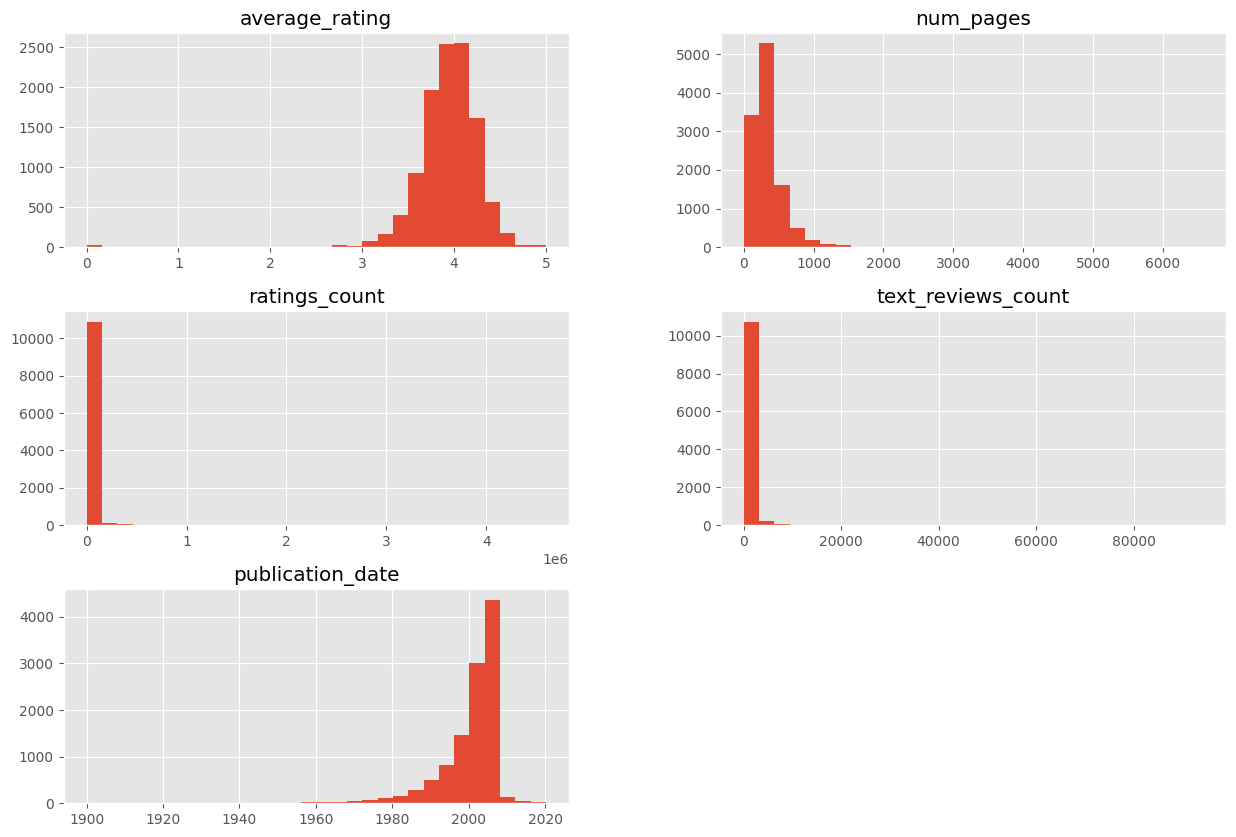

In [26]:
df[['average_rating', 'num_pages', 'ratings_count', \
    'text_reviews_count', \
    'publication_date']].hist(bins=30, figsize=(15, 10))
plt.show()

#### С помощью логарифмирования можно сделать «длиннохвостые» распределения более «гладкими»

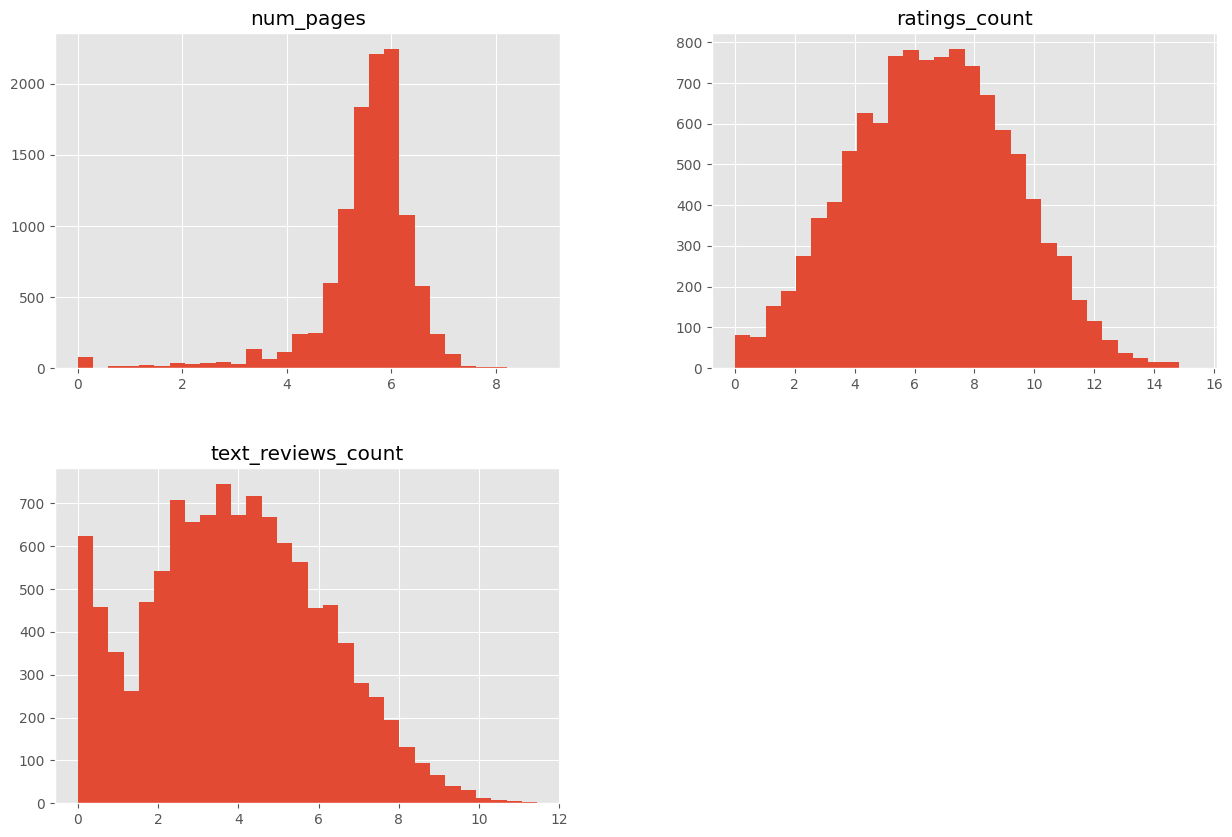

In [27]:
df[['num_pages', 'ratings_count', \
    'text_reviews_count']]\
.apply(lambda x: np.log(x + 1)).\
hist(bins=30, figsize=(15, 10))
plt.show()

## Выбор наиболее релевантных переменных для анализа

Оценка популярности книги может быть выполнена с использованием различных методов, которые можно разделить на несколько категорий: количественные показатели, качественные оценки и общественное мнение. Рассмотрим основные методы более подробно.

### **Количественные показатели**

1. **Продажи и тиражи**
   - Количество проданных экземпляров книги является одним из наиболее прямых и очевидных показателей её популярности. Высокие тиражи и частые допечатки свидетельствуют о большом интересе к книге.

2. **Библиотечные заимствования**
   - Статистика по заимствованиям книг в библиотеках также может служить индикатором популярности. Чем чаще книга берётся на прочтение, тем выше её популярность среди читателей.

3. **Онлайн-продажи и скачивания**
   - В эпоху цифровых технологий важным показателем популярности являются данные о продажах электронных книг и скачиваниях. Платформы вроде Amazon, LitRes и других предоставляют такую статистику[7].

### **Качественные оценки**

1. **Рецензии и отзывы**
   - Количество и качество рецензий и отзывов на различных платформах, таких как Goodreads, Лабиринт, Озон и других, также могут указывать на популярность книги. Положительные отзывы и высокие рейтинги способствуют росту интереса к произведению[2][8].

2. **Премии и награды**
   - Получение литературных премий и наград является важным показателем признания книги в литературных кругах. Такие награды привлекают внимание к произведению и могут значительно повысить его популярность[3].

### **Общественное мнение**

1. **Опросы и исследования**
   - Социологические опросы и исследования, проводимые организациями вроде ВЦИОМ, помогают определить, какие книги наиболее популярны среди различных групп населения. Эти данные могут включать информацию о предпочтениях по жанрам, авторам и форматам книг[5][10].

2. **Упоминания в СМИ и социальных сетях**
   - Частота упоминаний книги в прессе, на телевидении, в блогах и социальных сетях также является важным индикатором её популярности. Вирусное распространение информации о книге может значительно увеличить её популярность[8].

Таким образом, оценка популярности книги требует комплексного подхода, включающего анализ количественных данных, качественных оценок и общественного мнения. Использование различных методов позволяет получить более полное представление о том, насколько книга востребована и признана среди читателей.  

### **Наиболее релевантные целевые переменные**

В данной работе среди имеющихся данных в качестве целевой пременной, показывающей популярность книг, можно выделить **количество рецензий** (text_reviews_count) и **количество оценок** (ratings_count)

### **Предположения о зависимости популярности**

1. Популярность зависит от рейтинга
2. Популярность зависит от количества страниц
3. Популярность зависит от даты публикации

### Матрица корреляций

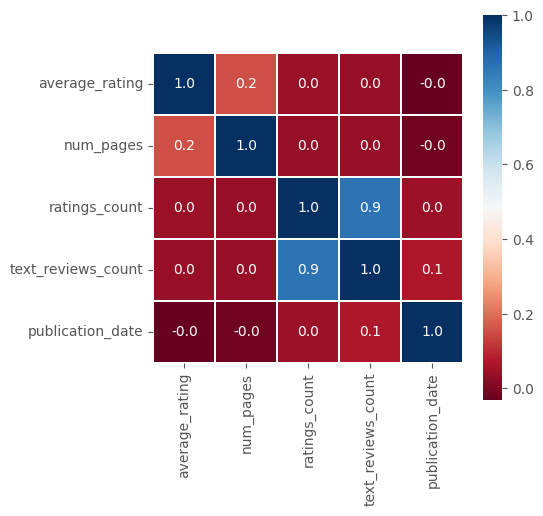

In [28]:
plt.subplots(figsize=(5, 5))

nums = df[['average_rating', 'num_pages',
           'ratings_count', 'text_reviews_count', \
           'publication_date']]

sns.heatmap(nums.corr(), square=True,\
              annot=True, fmt=".1f", linewidths=0.1, cmap="RdBu");

На матрице корреляций можно заметить:
- Очень слабую связь между **датой публикации** и **количеством рецензий**
- Слабую связь между **количеством страниц** и **средней оценкой**
- Сильную связь между двумя целевыми переменными

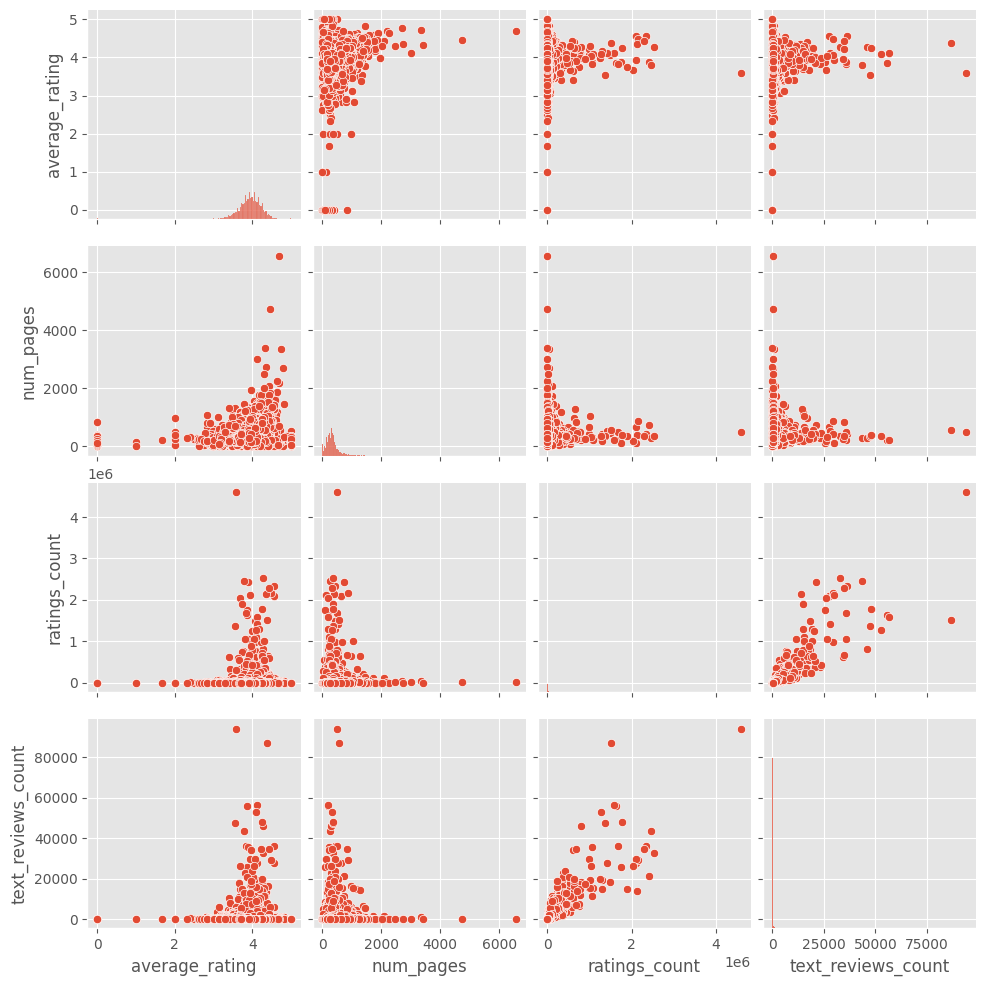

In [29]:
sns.pairplot(df[['average_rating', 'num_pages', 
                 'publication_date',
           'ratings_count', 'text_reviews_count']]);

На попарных диаграммах рассеяния можно заметить нелинейные зависимости

Запишем исправленные данные в csv-файл

In [30]:
df.to_csv('clean_books.csv', index=False)

Создадим БД

In [31]:
df = pd.read_csv('clean_books.csv')
con = sqlite3.connect('wb_books.db')
df.to_sql('books', con, \
          if_exists='replace', index=False)
con.close()

## Дополнение недостающих данных из Google Books

Считываю ключ к API Google Books

In [32]:
with open('key.txt') as f:
  key = f.read()

Для удобства запросов к API создаю функцию

In [33]:
def find_volume(querry):

    url = 'https://www.googleapis.com/books/v1/volumes?q='\
    + querry + '&key=' + key

    response = requests.get(url)
    print(response.json())

    if response.json().get('totalItems') != 0:
      final = response.json().get('items')
      if final != None:
          final = final[0]
          final = final['volumeInfo']
          if final != None:
              final = final.get('categories')
              return final
    print('Ошибка поиска по запросу: ' + querry)
    return None

Для каждого названия книги найдем ее жанр и запишем в БД  
Для этого создадим 6 ключей с разных аккаунтов и напишем многопоточную программу для парсинга

# 2. Запросы, триггеры и хранимые процедуры

Во избежание повторов в коде создадим функцию для запроса к **SQLite** БД

In [34]:
def sq(q):
    con = sqlite3.connect('test.db')
    con.execute("PRAGMA journal_mode=WAL;")
    if 'select' in q.lower():
        df = pd.read_sql_query(q, con)
        return df
    else:
        con.execute(q)
        con.commit()
    con.close()

### 2.1. Выведите список всех жанров книг в базе данных

In [35]:
q = '''

SELECT
    DISTINCT category
FROM
    BOOKS

'''
sq(q)

category
0           Juvenile Fiction
1           Boarding schools
2                    England
3                    Fiction
4                       None
..                       ...
846        Consumer behavior
847  Negotiation in business
848   Civilization, Medieval
849               Психология
850            Звуки природы

[851 rows x 1 columns]

### 2.2. Выведите количество книг, выпущенных в каждом году, отсортированное по убыванию

In [36]:
q = '''

SELECT 
    count(bookID) as books_published, 
    strftime('%Y', publication_date) AS year
FROM 
    BOOKS
GROUP BY
    year
ORDER BY 
    books_published DESC

'''
sq(q)

books_published  year
0              1700  2006
1              1260  2005
2              1068  2004
3               931  2003
4               798  2002
..              ...   ...
83                1  1922
84                1  1919
85                1  1914
86                1  1913
87                1  1900

[88 rows x 2 columns]

### 2.3. Выведите топ 10 самых популярных книг по среднему рейтингу

In [37]:
q = '''

SELECT
    bookID,
    title,
    average_rating
FROM
    BOOKS
ORDER BY
    average_rating DESC
LIMIT 10
    
'''
sq(q)

bookID                                              title  average_rating
0    2034  Comoediae 1: Acharenses/Equites/Nubes/Vespae/P...             5.0
1    2560                  Willem de Kooning: Late Paintings             5.0
2    2843  Literature Circle Guide: Bridge to Terabithia:...             5.0
3    4287  Middlesex Borough (Images of America: New Jersey)             5.0
4   14741  Zone of the Enders: The 2nd Runner Official St...             5.0
5   17224  The Diamond Color Meditation: Color Pathway to...             5.0
6   17830  Bulgakov's the Master and Margarita: The Text ...             5.0
7   18184  The Complete Theory Fun Factory: Music Theory ...             5.0
8   18240                                      War and Peace             5.0
9   19786  The Goon Show  Volume 4: My Knees Have Fallen ...             5.0

### 2.4. Выведите информацию о книгах, имеющих определенный жанр и рейтинг выше заданного значения (пользователь вводит жанр и рейтинг).

In [39]:
rating = int(input('Рейтинг должен быть больше чем: '))
category = input('Желаемый жанр')

q = f'''

SELECT *
FROM 
    BOOKS
WHERE
    category = '{category}'
    AND average_rating > {rating}

'''
sq(q)

Рейтинг должен быть больше чем:  4
Желаемый жанр Fiction


bookID                                              title  \
0         12  The Ultimate Hitchhiker's Guide: Five Complete...   
1         13  The Ultimate Hitchhiker's Guide to the Galaxy ...   
2         14  The Hitchhiker's Guide to the Galaxy (Hitchhik...   
3         16  The Hitchhiker's Guide to the Galaxy (Hitchhik...   
4         18  The Ultimate Hitchhiker's Guide (Hitchhiker's ...   
...      ...                                                ...   
1404   45485          The Subtle Knife (His Dark Materials  #2)   
1405   45486      His Dark Materials (His Dark Materials  #1-3)   
1406   45623   O Sobrinho do Mágico (As Crónicas de Nárnia  #1)   
1407   45631   Expelled from Eden: A William T. Vollmann Reader   
1408   45633                        You Bright and Risen Angels   

                                                authors  average_rating  \
0                                         Douglas Adams            4.38   
1                                         Douglas Adams            4.38   
2                                         Douglas Adams            4.22   
3                             Douglas Adams/Stephen Fry            4.22   
4                                         Douglas Adams            4.38   
...                                                 ...             ...   
1404                                     Philip Pullman            4.13   
1405                                     Philip Pullman            4.26   
1406        C.S. Lewis/Pauline Baynes/Ana Falcão Bastos            4.04   
1407  William T. Vollmann/Larry McCaffery/Michael He...            4.06   
1408                                William T. Vollmann            4.08   

            isbn         isbn13 language_code  num_pages  ratings_count  \
0     0517226952  9780517226957           eng        815           3628   
1     0345453743  9780345453747           eng        815         249558   
2     1400052920  9781400052929           eng        215           4930   
3     0739322206  9780739322208           eng          6           1266   
4     0517149257  9780517149256           eng        815           2877   
...          ...            ...           ...        ...            ...   
1404  0807210471  9780807210475           eng          8             39   
1405  0375847227  9780375847226           eng        933           2656   
1406  9722329987  9789722329989           por        147            396   
1407  1560254416  9781560254416           eng        512            156   
1408  0140110879  9780140110876           eng        635            783   

      text_reviews_count publication_date           publisher  \
0                    254       2005-11-01      Gramercy Books   
1                   4080       2002-04-30       Del Rey Books   
2                    460       2004-08-03               Crown   
3                    253       2005-03-23  Random House Audio   
4                    195       1996-01-17         Wings Books   
...                  ...              ...                 ...   
1404                   8       2000-01-28   Listening Library   
1405                 260       2007-04-10     Alfred A. Knopf   
1406                  37       2003-04-08  Editorial Presença   
1407                  20       2004-12-21       Da Capo Press   
1408                  56       1988-12-01       Penguin Books   

      av_rating_discrete category description  
0                   4.38  Fiction        None  
1                   4.38  Fiction        None  
2                   4.22  Fiction        None  
3                   4.22  Fiction        None  
4                   4.38  Fiction        None  
...                  ...      ...         ...  
1404                4.13  Fiction        None  
1405                4.26  Fiction        None  
1406                4.04  Fiction        None  
1407                4.06  Fiction        None  
1408                4.08  Fiction        None  

[1409 rows x 15 columns]

### 2.5. Выведите средний рейтинг книг по жанрам.

In [40]:
q = '''

SELECT
    AVG(average_rating) as avg_rating,
    category
FROM
    BOOKS
GROUP BY
    category

'''
sq(q)

avg_rating                category
0      3.898414                    None
1      3.570000                    20th
2      3.960000         Abandoned mines
3      3.650000  Achievement motivation
4      3.650000                  Acting
..          ...                     ...
846    4.028750  Young Adult Nonfiction
847    3.520000     Young adult fiction
848    4.100000             Young women
849    5.000000           Звуки природы
850    5.000000              Психология

[851 rows x 2 columns]

### 2.6. Выведите список книг, написанных определенным автором (пользователь вводит имя автора).

In [41]:
author = input('Имя автора:')
q = f'''

SELECT *
FROM
    BOOKS
WHERE
    authors LIKE '%{author}%'

'''
sq(q)

Имя автора: Mark Twain


bookID                                              title  \
0     2443                               The Innocents Abroad   
1     2834  The Tragedy of Pudd'nhead Wilson/Those Extraor...   
2     2835                   The Tragedy of Pudd'nhead Wilson   
3     2949  Huck Finn & Tom Sawyer among the Indians & Oth...   
4     2952         Huck Finn and Tom Sawyer Among the Indians   
5     2953  Huck Finn/Pudd'nhead Wilson/No 44 Mysterious S...   
6     2956  The Adventures of Huckleberry Finn (Adventures...   
7     2958                     Adventures of Huckleberry Finn   
8     2960                     Adventures of Huckleberry Finn   
9     2962                     The Annotated Huckleberry Finn   
10    2965                   The Wit and Wisdom of Mark Twain   
11    2967  Mark Twain's Helpful Hints for Good Living: A ...   
12    2968           The Complete Short Stories of Mark Twain   
13    2971                    The Autobiography of Mark Twain   
14    2973  Collected Tales  Sketches  Speeches  & Essays ...   
15   19370                 The Adventures of Huckleberry Finn   
16   19371                 The Adventures of Huckleberry Finn   
17   19373        Mark Twain's Adventures of Huckleberry Finn   
18   19377  Collected Tales  Sketches  Speeches  & Essays ...   
19   19379  Mark Twain's Own Autobiography: The Chapters f...   
20   24580  The Adventures of Tom Sawyer and Adventures of...   
21   24581  The Adventures of Tom Sawyer (Adventures of To...   
22   24583  The Adventures of Tom Sawyer (Adventures of To...   
23   31235  Historical Romances: The Prince and the Pauper...   
24   37813        Letters from the Earth: Uncensored Writings   
25   37815                         Mark Twain: Selected Works   
26   38680                     Adventures of Huckleberry Finn   
27   38747                                        Roughing It   
28   38750                  The Complete Essays of Mark Twain   
29   43441                                     A Tramp Abroad   
30   45641                        Las aventuras de Tom Sawyer   

                                              authors  average_rating  \
0                           Mark Twain/Grover Gardner            3.86   
1   Mark Twain/David Lionel Smith/Sherley Anne Wil...            3.79   
2                         Mark Twain/Michael Prichard            3.79   
3   Mark Twain/Paul Baender/Dahlia Armon/Walter Blair            3.85   
4                               Mark Twain/Lee Nelson            3.57   
5               Mark Twain/Guy Cardwell/Louis J. Budd            4.06   
6    Mark Twain/Guy Cardwell/John Seelye/Walter Trier            3.82   
7                              Mark Twain/E.W. Kemble            3.82   
8                          Mark Twain/George Saunders            3.82   
9        Mark Twain/Michael Patrick Hearn/E.W. Kemble            3.82   
10                                         Mark Twain            4.20   
11  Mark Twain/Lin Salamo/Victor Fischer/Michael B...            3.86   
12                          Mark Twain/Charles Neider            4.28   
13                          Mark Twain/Charles Neider            4.05   
14                           Mark Twain/Louis J. Budd            4.39   
15              Mark Twain/Scott McKowen/Arthur Pober            3.82   
16                           Mark Twain/Peter Coveney            3.82   
17                     Mark Twain/Richard P. Wasowski            3.82   
18                           Mark Twain/Louis J. Budd            4.29   
19                       Mark Twain/Michael J. Kiskis            3.80   
20                   Mark Twain/Shelly Fisher Fishkin            4.08   
21                           Mark Twain/Scott McKowen            3.91   
22                Mark Twain/Guy Cardwell/John Seelye            3.91   
23                         Mark Twain/Susan K. Harris            4.38   
24         Mark Twain/Bernard DeVoto/Henry Nash Smith            4.21   
25                       

### 2.7. Выведите информацию о книгах с определенным количеством страниц (например, более 500 страниц).


In [42]:
num = int(input('Страниц в книге больше чем: '))
q = f'''

SELECT *
FROM
    BOOKS
WHERE
    num_pages > {num}

'''
sq(q)

Страниц в книге больше чем:  500


bookID                                              title  \
0          1  Harry Potter and the Half-Blood Prince (Harry ...   
1          2  Harry Potter and the Order of the Phoenix (Har...   
2          8  Harry Potter Boxed Set  Books 1-5 (Harry Potte...   
3         10       Harry Potter Collection (Harry Potter  #1-6)   
4         12  The Ultimate Hitchhiker's Guide: Five Complete...   
...      ...                                                ...   
1732   45583                      Historia del rey transparente   
1733   45592                       La tía Julia y el escribidor   
1734   45607                             Las Crónicas de Narnia   
1735   45631   Expelled from Eden: A William T. Vollmann Reader   
1736   45633                        You Bright and Risen Angels   

                                                authors  average_rating  \
0                            J.K. Rowling/Mary GrandPré            4.57   
1                            J.K. Rowling/Mary GrandPré            4.49   
2                            J.K. Rowling/Mary GrandPré            4.78   
3                                          J.K. Rowling            4.73   
4                                         Douglas Adams            4.38   
...                                                 ...             ...   
1732                                       Rosa Montero            3.90   
1733                                 Mario Vargas Llosa            3.92   
1734  C.S. Lewis/Margarita E. Valdes/Gemma Gallart/P...            4.26   
1735  William T. Vollmann/Larry McCaffery/Michael He...            4.06   
1736                                William T. Vollmann            4.08   

            isbn         isbn13 language_code  num_pages  ratings_count  \
0     0439785960  9780439785969           eng        652        2095690   
1     0439358078  9780439358071           eng        870        2153167   
2     0439682584  9780439682589           eng       2690          41428   
3     0439827604  9780439827607           eng       3342          28242   
4     0517226952  9780517226957           eng        815           3628   
...          ...            ...           ...        ...            ...   
1732  8466318771  9788466318778           spa        592           1266   
1733  8466302298  9788466302296           spa        566            162   
1734  0061199001  9780061199004           spa        816            186   
1735  1560254416  9781560254416           eng        512            156   
1736  0140110879  9780140110876           eng        635            783   

      text_reviews_count publication_date              publisher  \
0                  27591       2006-09-16        Scholastic Inc.   
1                  29221       2004-09-01        Scholastic Inc.   
2                    164       2004-09-13             Scholastic   
3                    808       2005-09-12             Scholastic   
4                    254       2005-11-01         Gramercy Books   
...                  ...              ...                    ...   
1732                  90       2006-09-01       Punto de Lectura   
1733                  10       2001-03-01                   Suma   
1734                  11       2006-11-07  HarperCollins Espanol   
1735                  20       2004-12-21          Da Capo Press   
1736                  56       1988-12-01          Penguin Books   

      av_rating_discrete          category description  
0                   4.57  Juvenile Fiction        None  
1                   4.49  Juvenile Fiction        None  
2                   4.78  Juvenile Fiction        None  
3                   4.73              None        None  
4                   4.38           Fiction        None  
...                  ...               ...         ...  
1732                3.90           Fiction        None  
1733                3.92           Fiction        None  
1734                4.26              None        None  
1735        

### 2.8. Выведите количество книг с определенным рейтингом.

In [43]:
num = int(input('Рейтинг книги: '))
q = f'''

SELECT 
    count(bookID) as with_this_rating
FROM 
    BOOKS
WHERE
    average_rating = {num}

'''
sq(q)

Рейтинг книги:  4


with_this_rating
0               219

### 2.9. Выведите список книг с наибольшим количеством оценок.

In [44]:
q = '''

SELECT *
FROM
    BOOKS
WHERE
    ratings_count = (SELECT MAX(ratings_count) FROM books)

'''
sq(q)

bookID                    title          authors  average_rating  \
0   41865  Twilight (Twilight  #1)  Stephenie Meyer            3.59   

         isbn         isbn13 language_code  num_pages  ratings_count  \
0  0316015849  9780316015844           eng        501        4597666   

   text_reviews_count publication_date                  publisher  \
0               94265       2006-09-06  Little  Brown and Company   

   av_rating_discrete          category description  
0                3.59  Juvenile Fiction        None

In [45]:
q = '''

SELECT 
    title, 
    authors, 
    ratings_count
FROM 
    BOOKS
ORDER BY 
    ratings_count DESC
LIMIT 5

'''
sq(q)

title  \
0                            Twilight (Twilight  #1)   
1                The Hobbit  or There and Back Again   
2                             The Catcher in the Rye   
3               Angels & Demons (Robert Langdon  #1)   
4  Harry Potter and the Prisoner of Azkaban (Harr...   

                      authors  ratings_count  
0             Stephenie Meyer        4597666  
1              J.R.R. Tolkien        2530894  
2               J.D. Salinger        2457092  
3                   Dan Brown        2418736  
4  J.K. Rowling/Mary GrandPré        2339585

### 2.10. Выведите средний рейтинг книг, выпущенных в определенном году (пользователь вводит год).

In [46]:
num = int(input('Год выпуска книг: '))
q = f'''

SELECT
    AVG(average_rating) as av_av_rating,
    strftime('%Y', publication_date) AS year
FROM
    BOOKS
WHERE
    year = '{num}'

'''
sq(q)

Год выпуска книг:  2000


av_av_rating  year
0      3.922266  2000

## Триггеры

### Триггер 1: При добавлении новой книги в базу данных, автоматически записывать в лог информацию о дате и времени добавления.

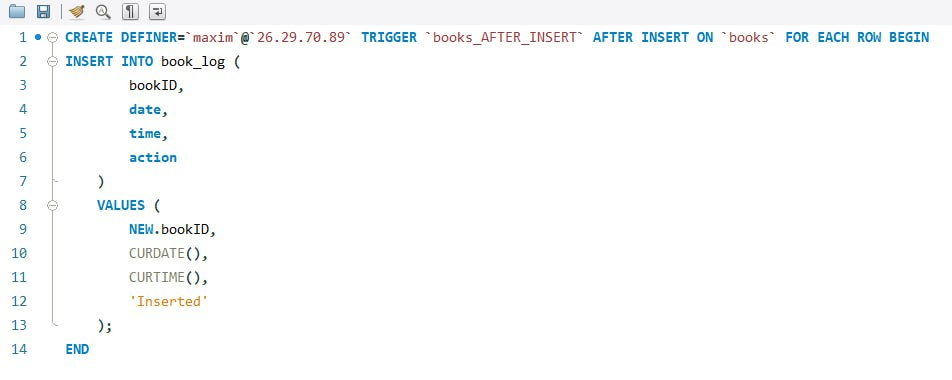

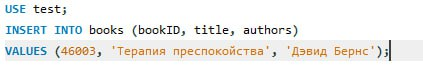

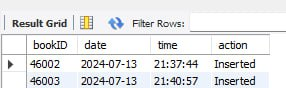

### Триггер 2: При изменении рейтинга книги, автоматически обновлять ее описание в базе данных

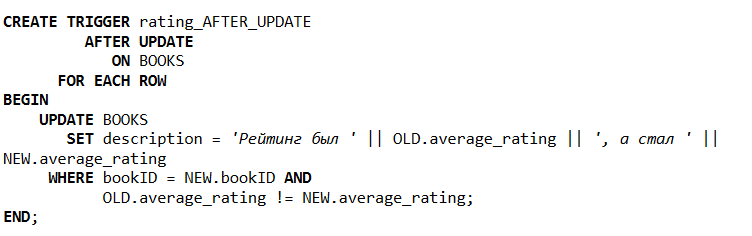

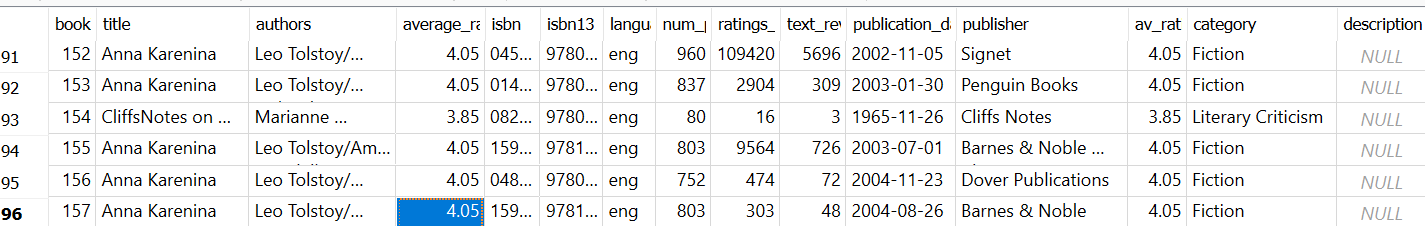

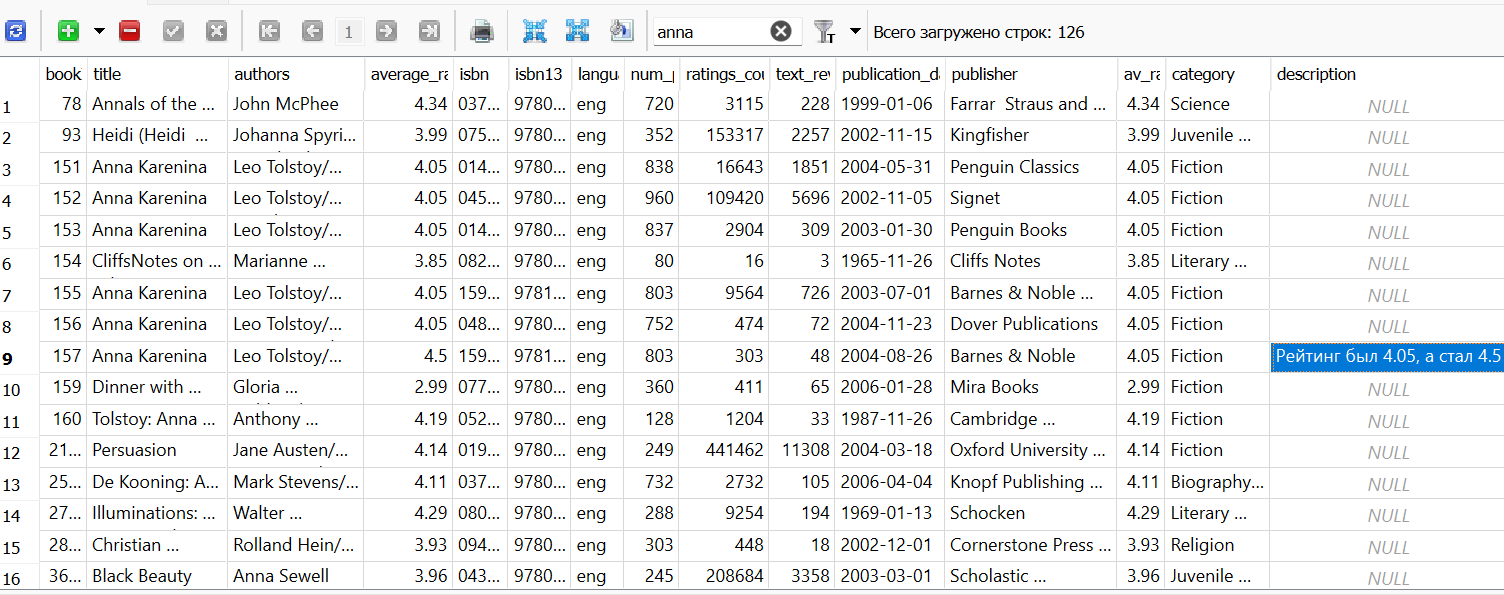

### Триггер 3: При удалении книги из базы данных, записывать в лог информацию о дате и времени удаления.

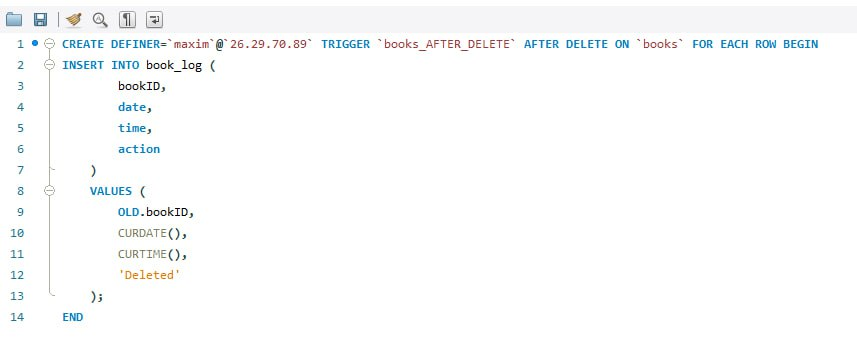

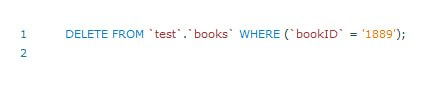

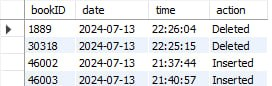

### Триггер 4: При добавлении нового жанра, автоматически создавать таблицу для хранения информации о книгах этого жанра.

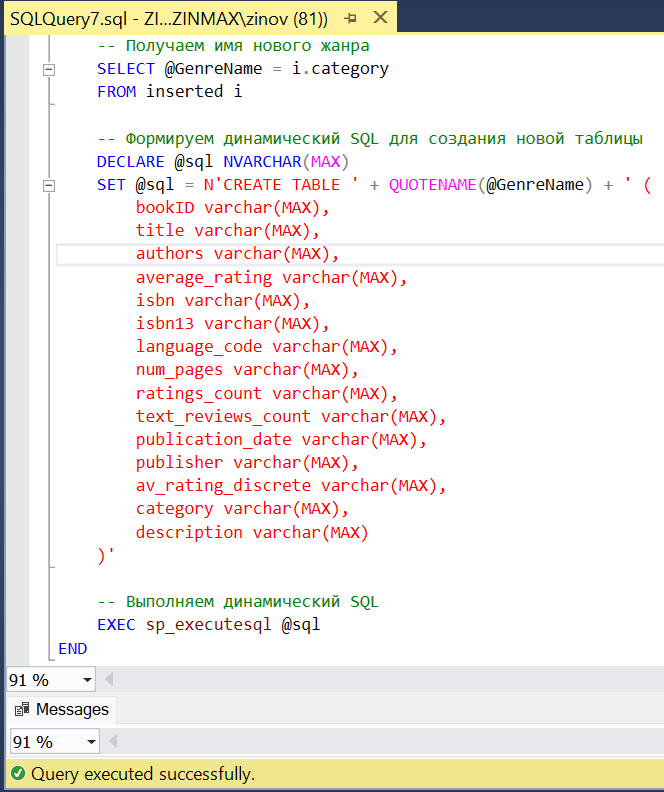

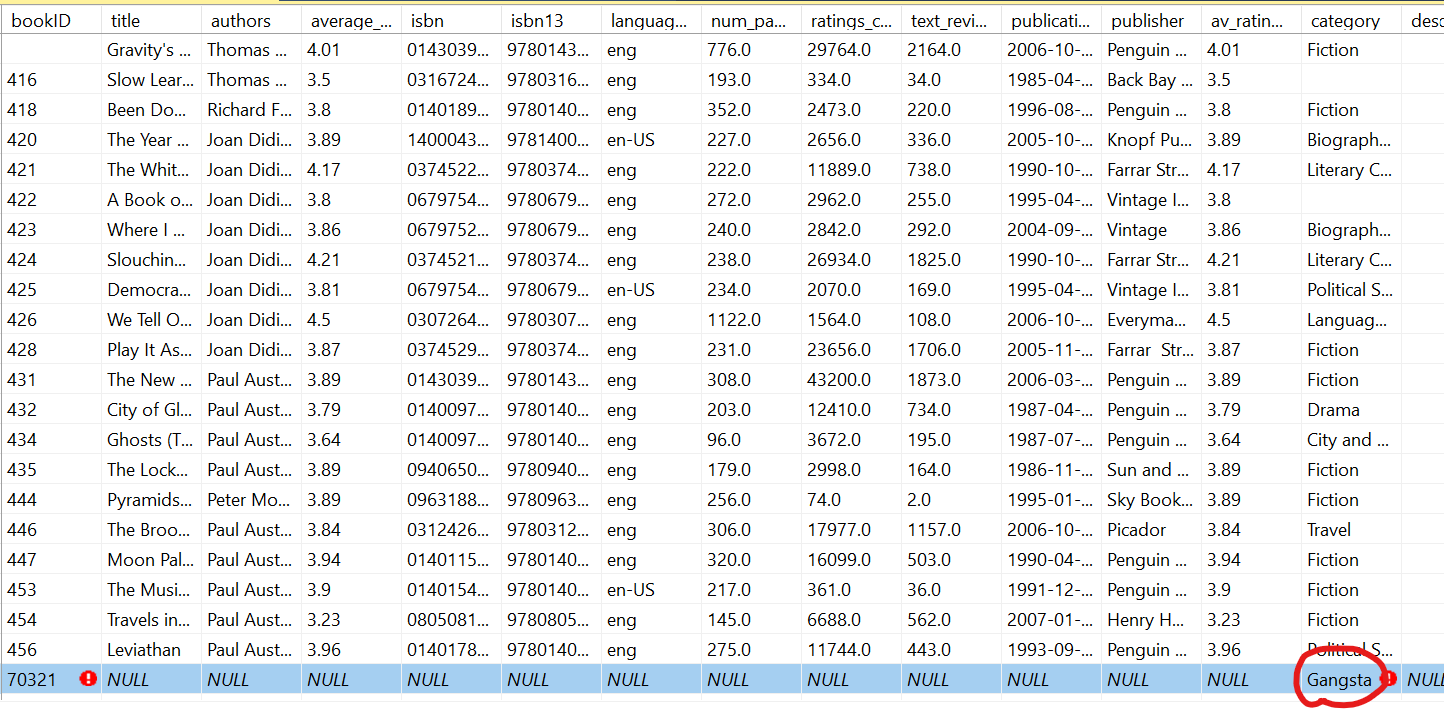

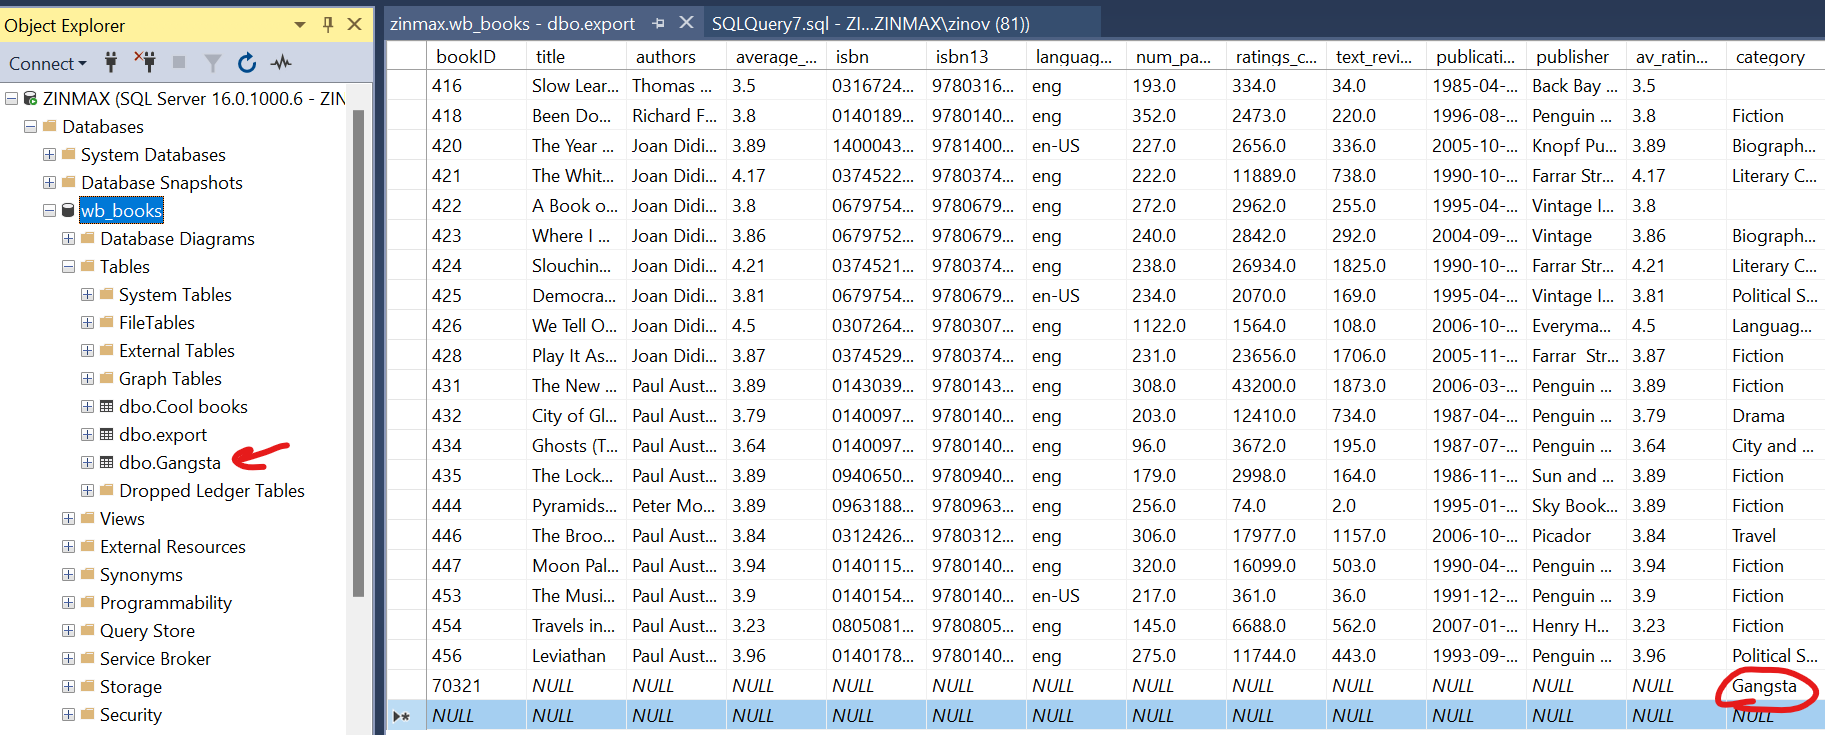

### Триггер 5: При изменении информации об авторе, автоматически обновлять информацию о книгах, написанных этим автором.

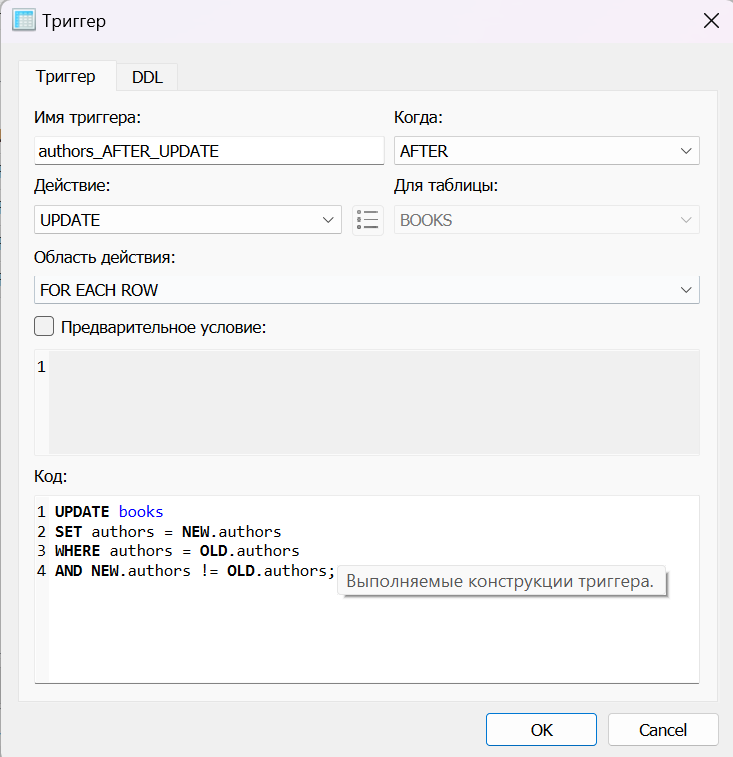

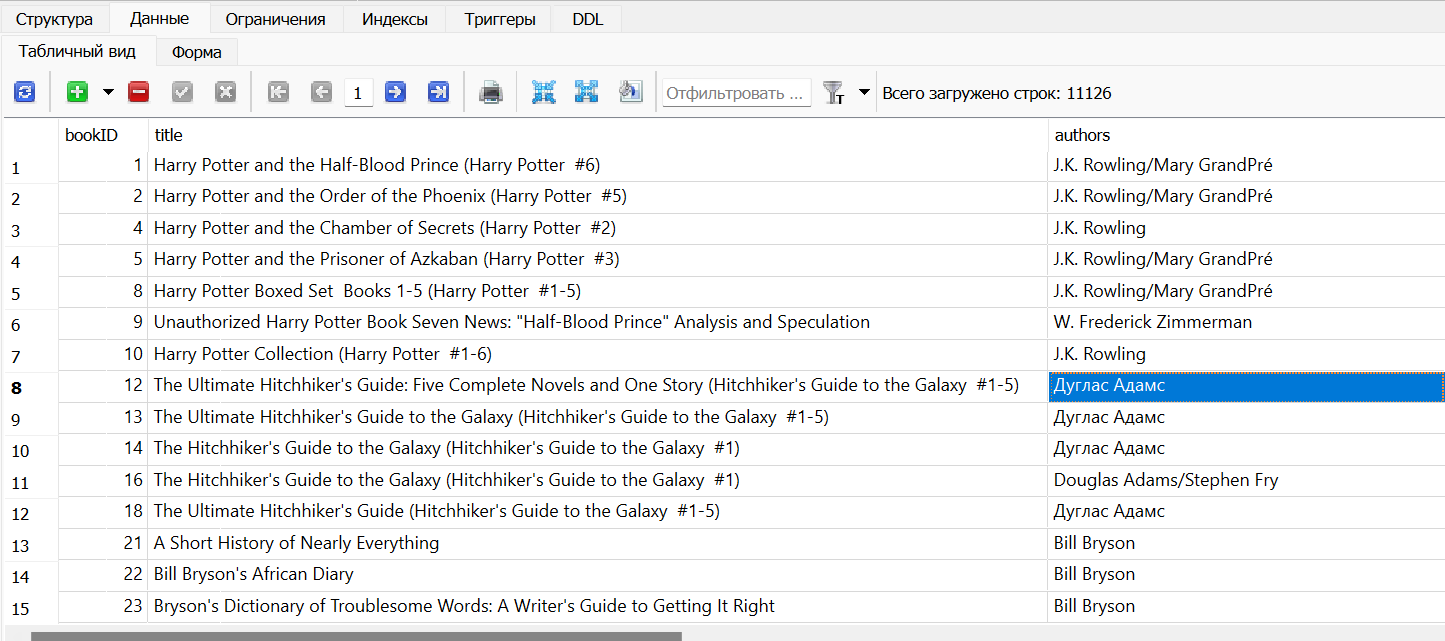

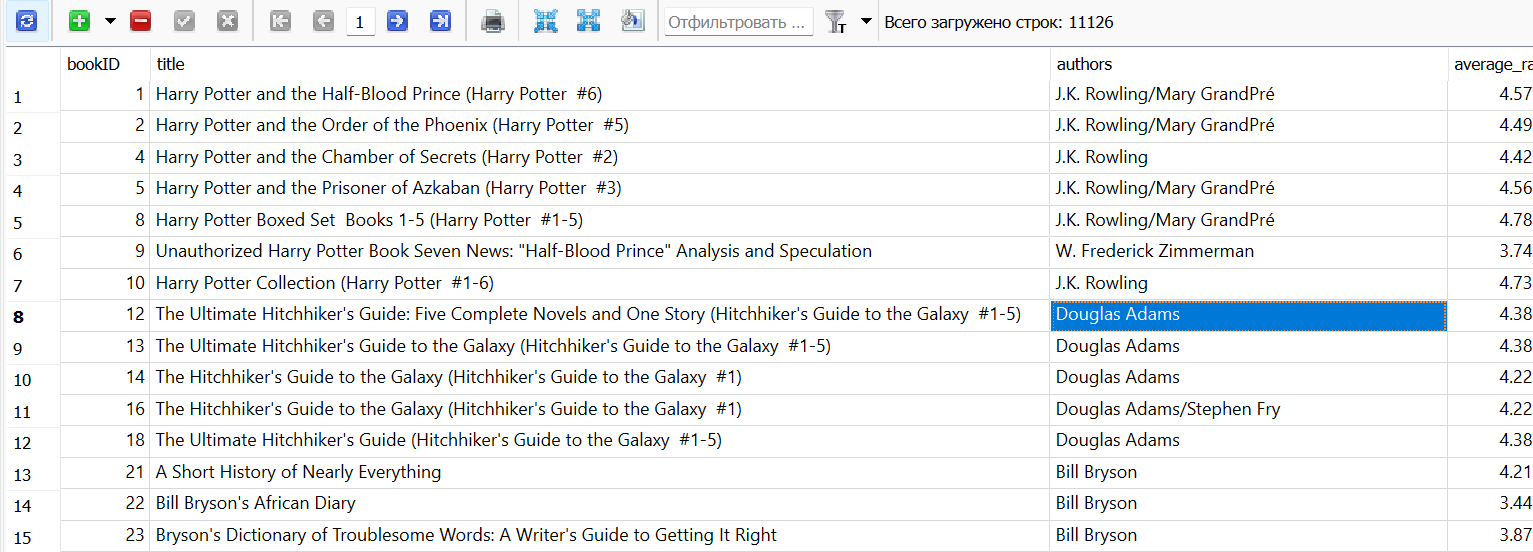

## Хранимые процедуры

### Процедура 1: Возвращать список книг, соответствующих заданным критериям поиска (жанр, автор, год выпуска, рейтинг, количество страниц).

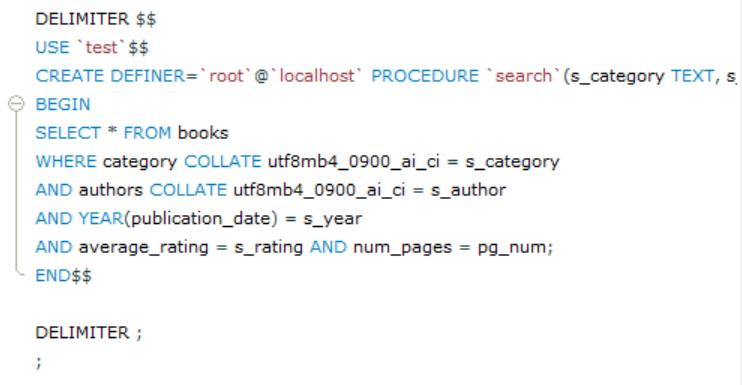

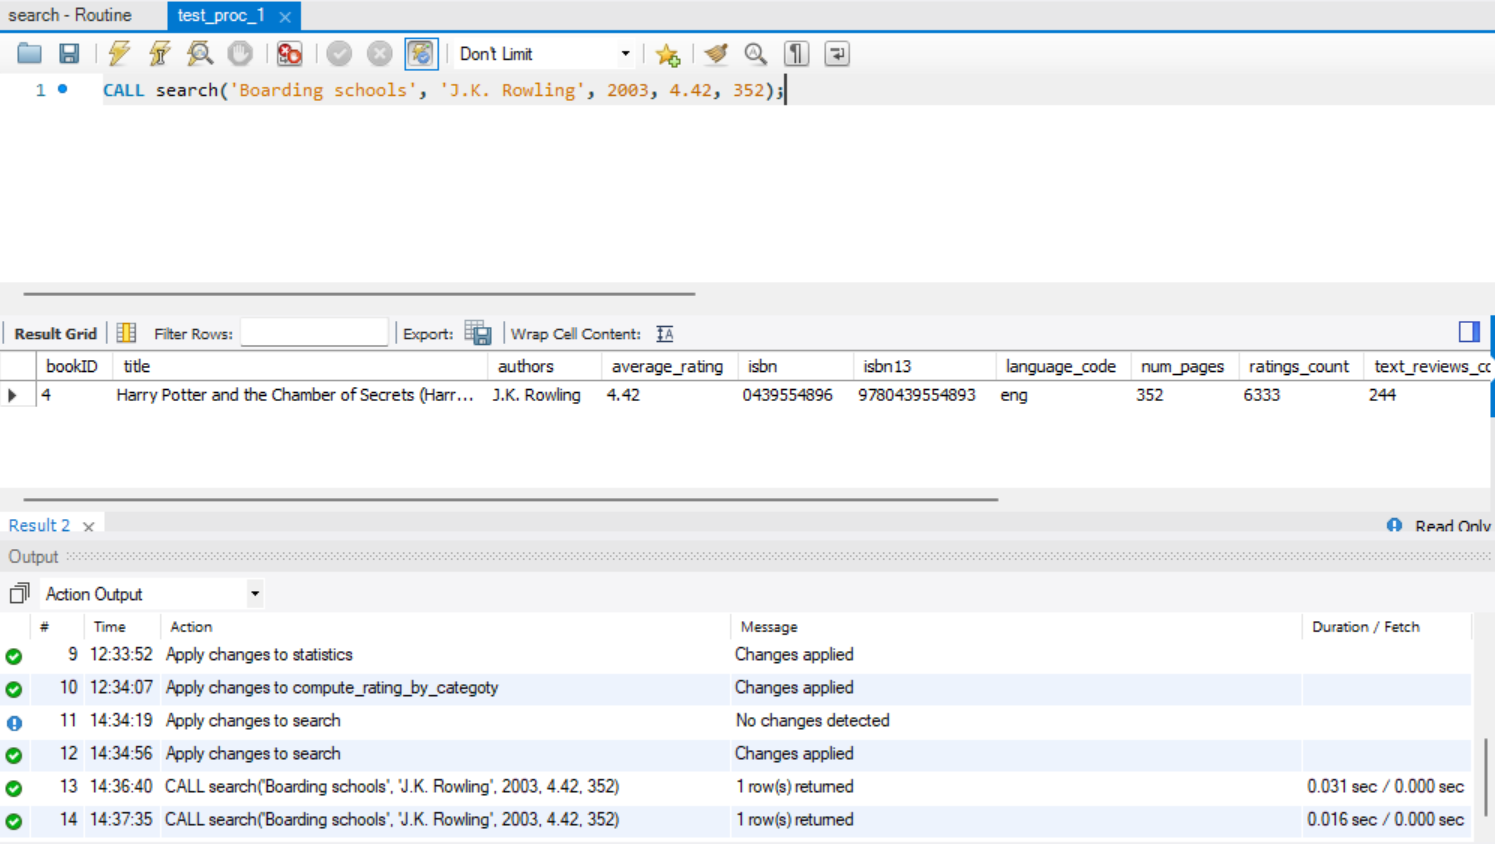

### Процедура 2: Вычислять средний рейтинг книг определенного жанра

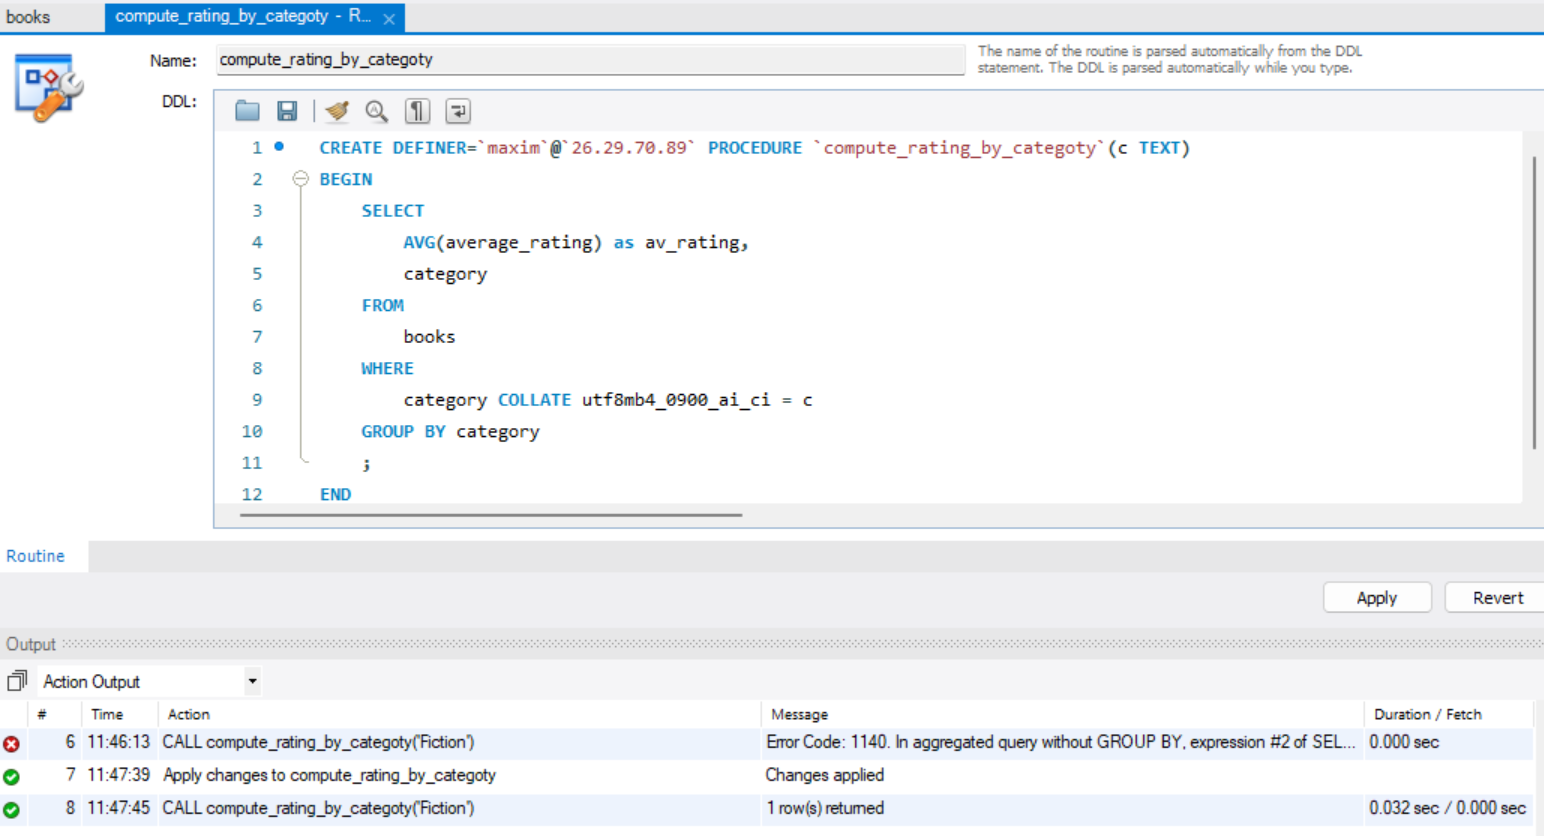

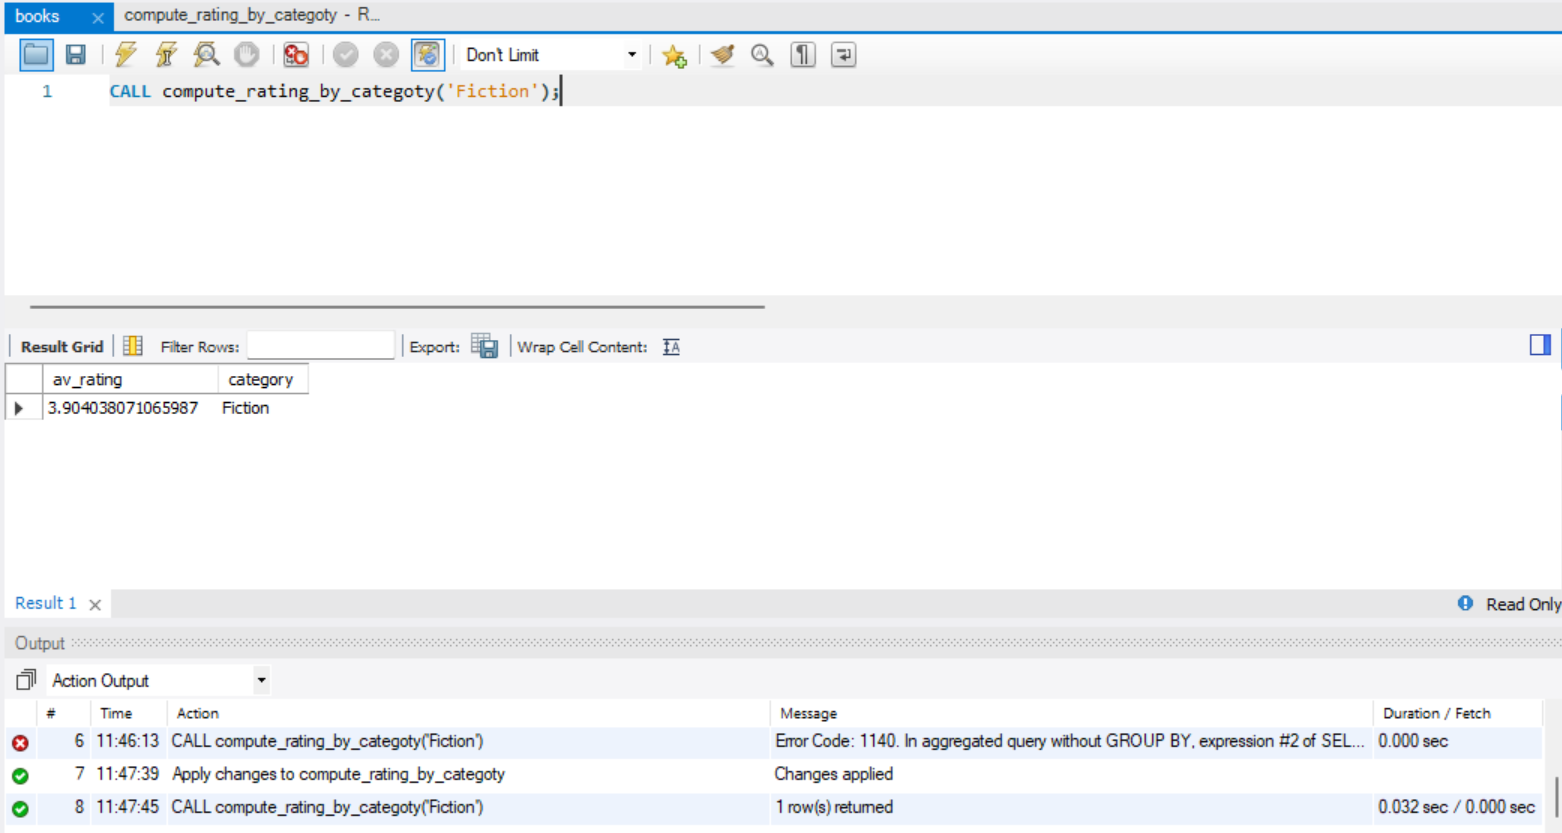

### Процедура 3: Определять топ 5 самых популярных книг по среднему рейтингу.

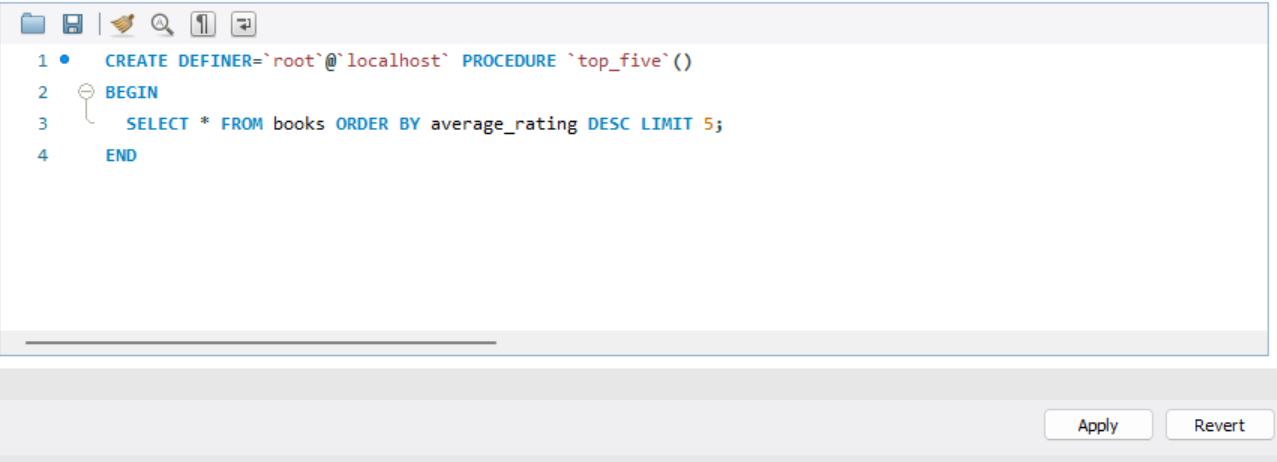

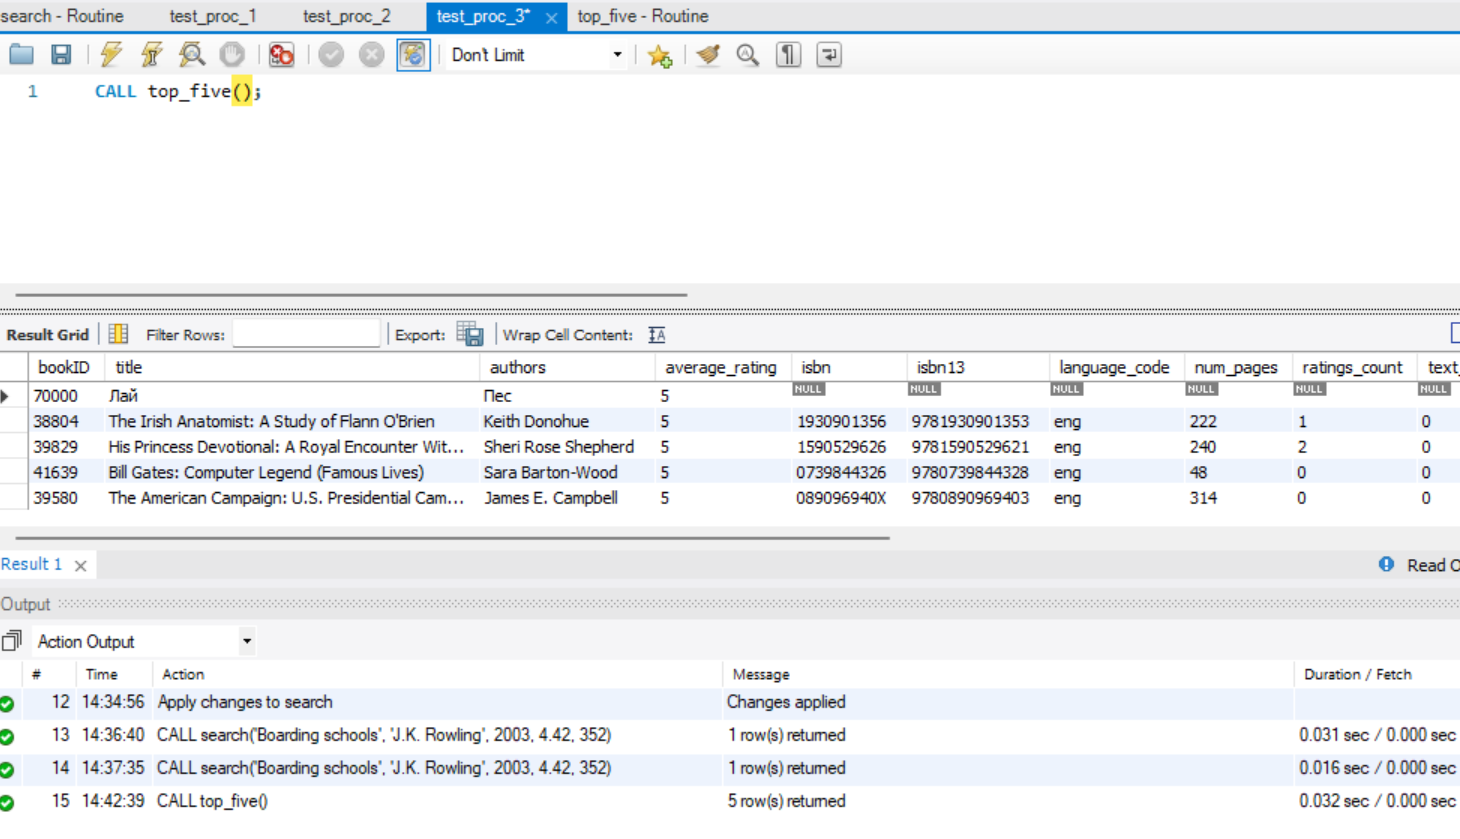

### Процедура 4: Выводить статистику по книгам (количество книг по жанрам, авторам, годам выпуска) в виде таблицы.

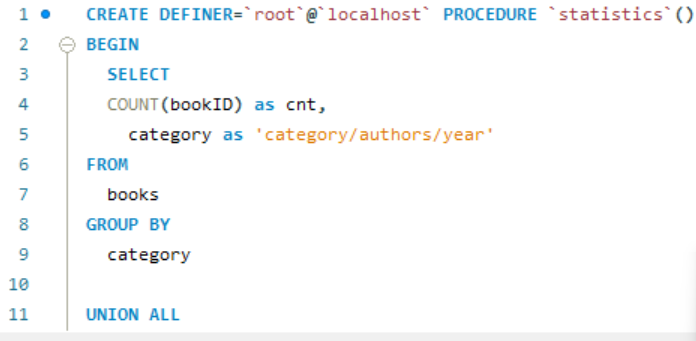

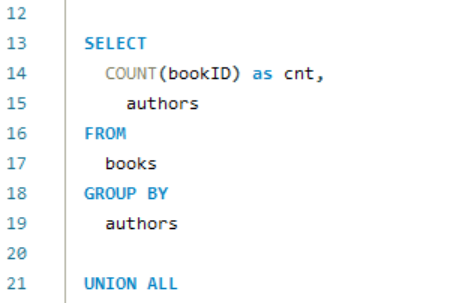

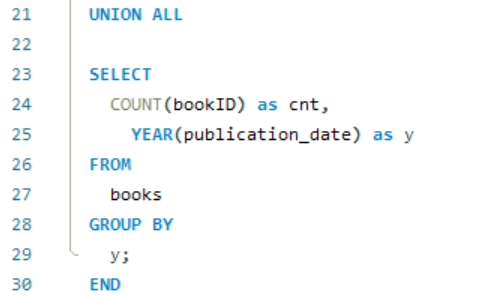

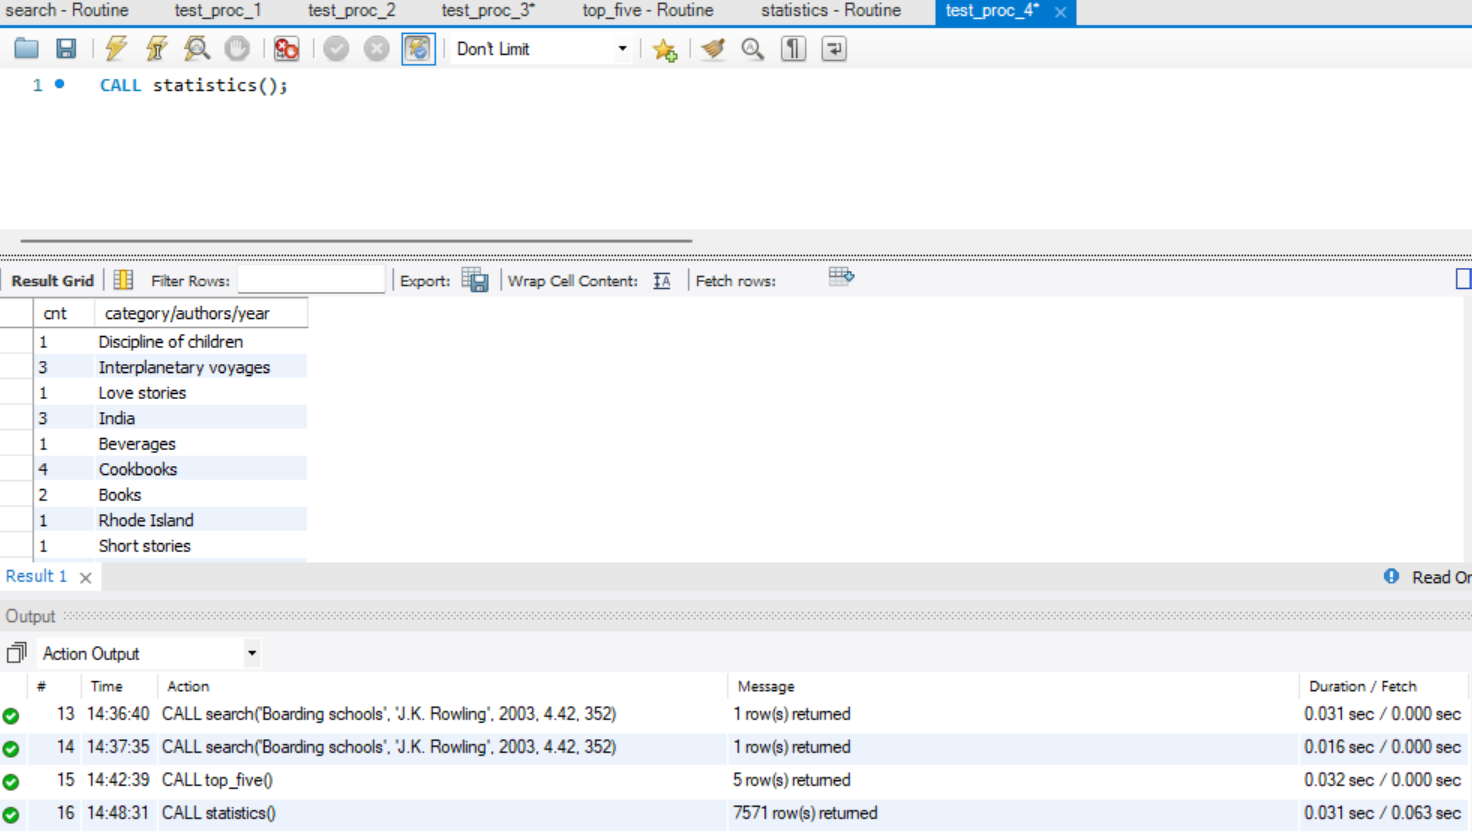

### Процедура 5: Вычислять среднее количество оценок книг, выпущенных в определенном году.

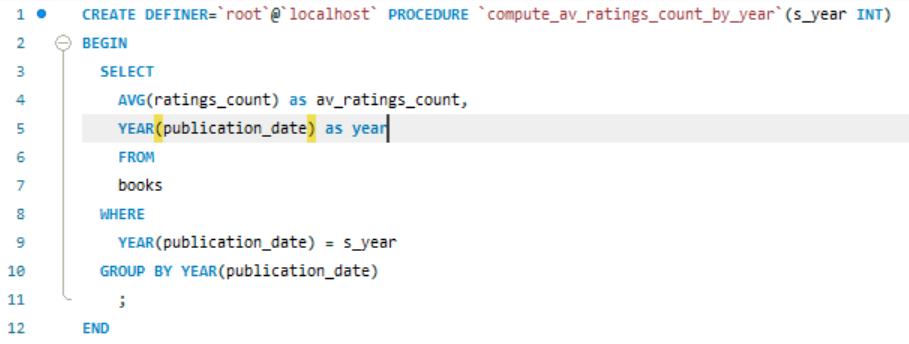

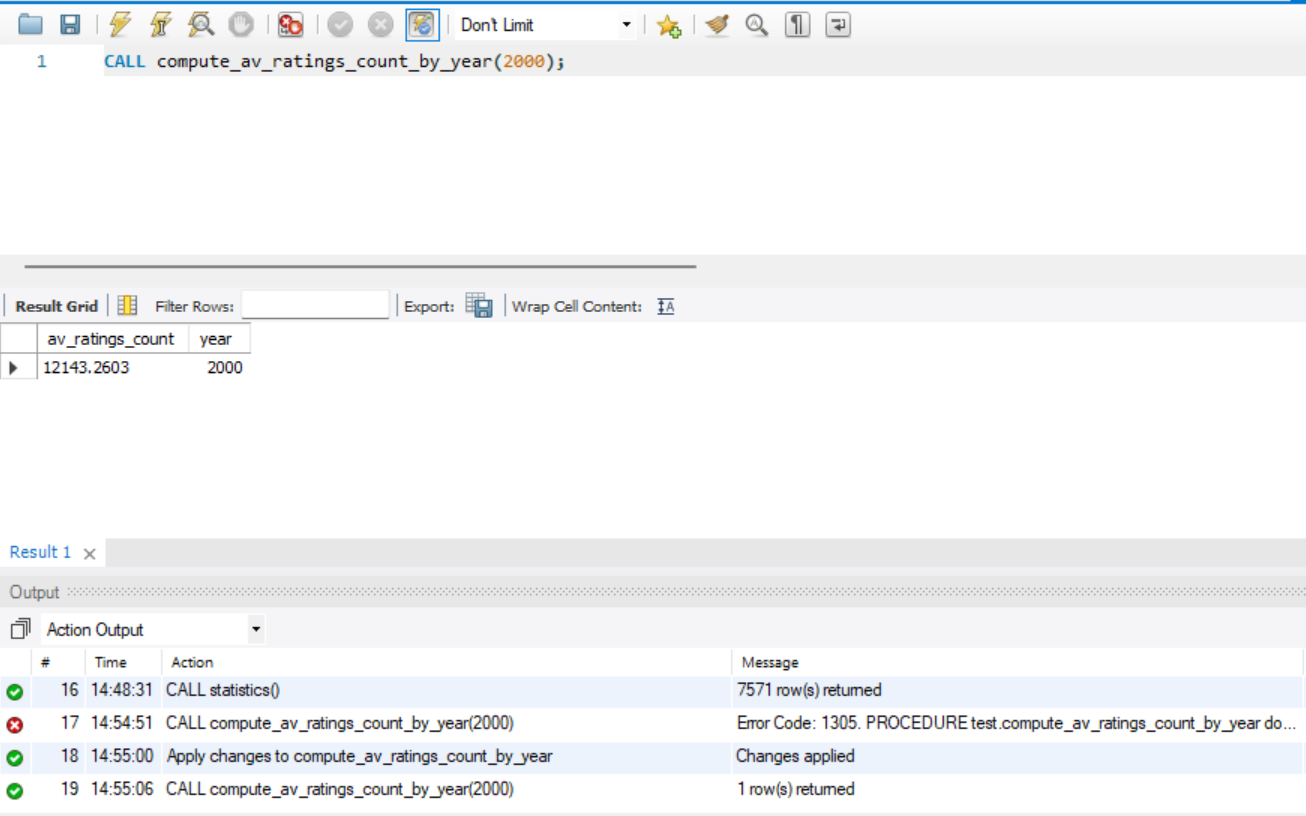

In [95]:
q = '''

SELECT 
    *
FROM 
    BOOKS

'''
df = sq(q)

# 3 Визуализация данных в Jupyter Notebook

### Визуализация 1: Постройте гистограмму распределения рейтинга книг.

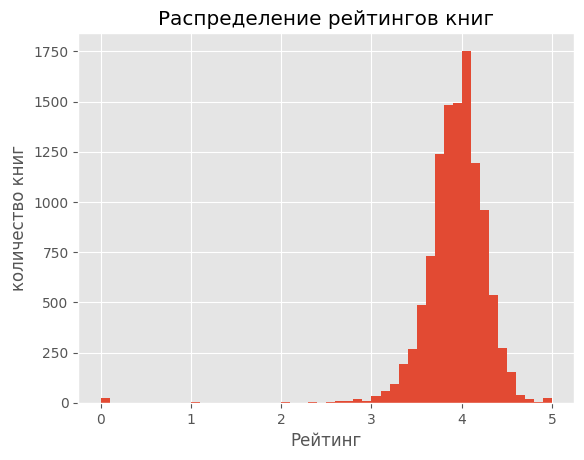

In [96]:
df.average_rating.hist(bins=50)
plt.title('Распределение рейтингов книг')
plt.xlabel('Рейтинг')
plt.ylabel('количество книг')
plt.show()

- Основная масса рейтингов лежит в окрестности 4
- Много выбросов около 0, 5, 1 и 2, они могут быть связаны с тем, что пользователи привыкли к целочисленным оценкам со времен школы и поэтому выставляют их чаще, а также с тем что плохих книг очень мало

### Визуализация 2: С помощью диаграммы столбцов сравните количество книг по жанрам.

In [97]:
print(f"Всего в данных {df.category.nunique()} жанров (категорий)")

Всего в данных 850 жанров (категорий)


In [98]:
print(f"Из них {sum(df.groupby('category').size() > 100)} жанров встречаются более 100 раз")

Из них 15 жанров встречаются более 100 раз


In [99]:
main_categories = df.groupby('category').size()[df.groupby('category').size() > 100]

**15 основных жанров:**

In [100]:
main_categories

category
Biography & Autobiography     548
Business & Economics          164
Comics & Graphic Novels       301
Drama                         178
Fiction                      3932
History                       406
Juvenile Fiction              656
Juvenile Nonfiction           120
Literary Collections          139
Literary Criticism            216
Philosophy                    204
Religion                      212
Science                       142
Social Science                117
Young Adult Fiction           106
dtype: int64

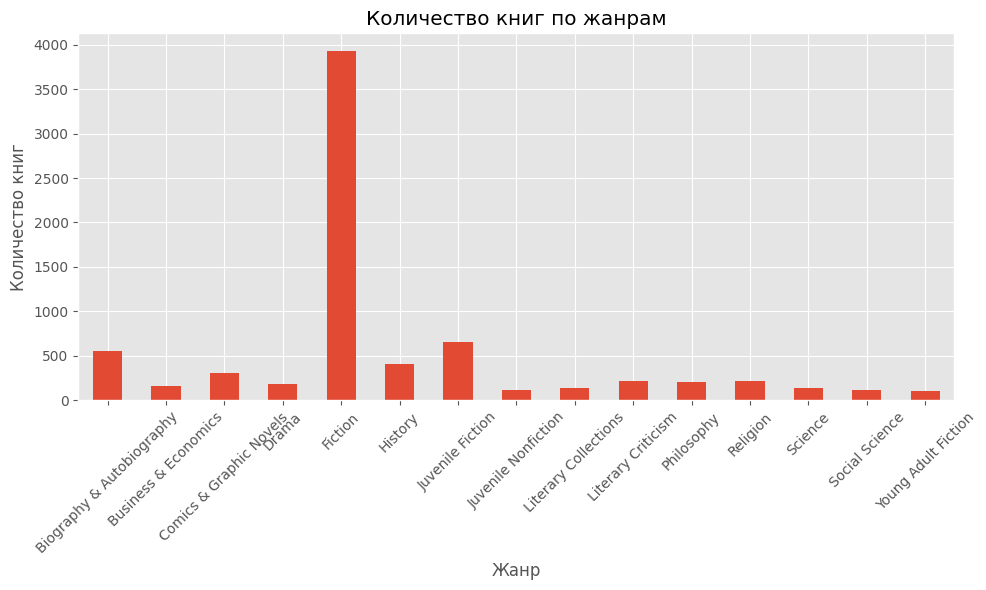

In [101]:
plt.figure(figsize=(10, 6))
main_categories.plot(kind='bar')
plt.title('Количество книг по жанрам')
plt.xlabel('Жанр')
plt.ylabel('Количество книг')
plt.xticks(rotation=45)
plt.tight_layout()

Из столбчатой диграммы видно, что наиболее распространенными жанрами являются:
1. Художественная литература
2. Детская художественная литература
3. Биографии
4. История
5. Бизнес и экономика

При этом количество художественной литературы во много раз больше

### Визуализация 3: Создайте scatter plot зависимости рейтинга книги от количества оценок.

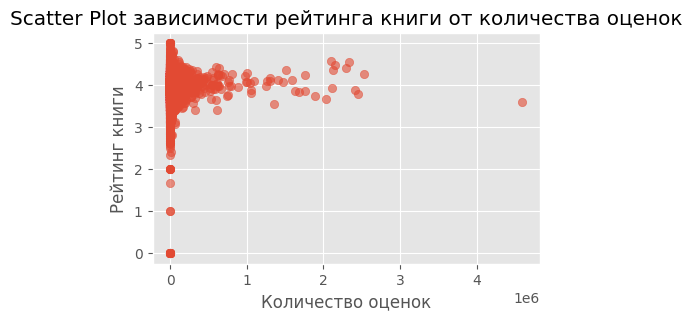

In [102]:
plt.figure(figsize=(5, 3))
plt.scatter(df.ratings_count, df.average_rating, alpha=0.6)
plt.title('Scatter Plot зависимости рейтинга книги от количества оценок')
plt.xlabel('Количество оценок')
plt.ylabel('Рейтинг книги')
plt.grid(True)
plt.show()

- Зависимость нелинейная
- Зависимость больше похожа на прямую, чем на обратную

### Визуализация 4: Постройте line chart зависимости среднего рейтинга книг от времени.

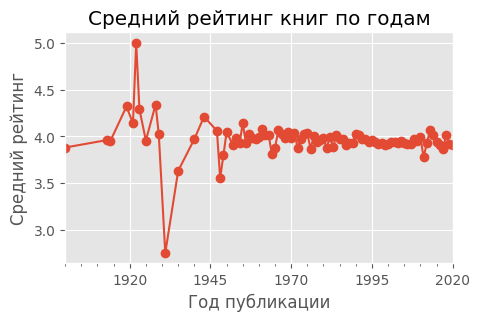

In [103]:
# Преобразуем столбец publication_date в формат datetime
df['publication_date'] = pd.to_datetime(df['publication_date'])

# Группируем данные по году публикации и рассчитываем средний рейтинг
df['year'] = df['publication_date'].dt.to_period('Y')
average_ratings = df.groupby('year')['average_rating'].mean()

# Строим график
plt.figure(figsize=(5, 3))
average_ratings.plot(kind='line', marker='o')
plt.title('Средний рейтинг книг по годам')
plt.xlabel('Год публикации')
plt.ylabel('Средний рейтинг')
plt.grid(True)
plt.show()

In [105]:
# Группируем данные по году и месяцу публикации и рассчитываем средний рейтинг
df['year_month'] = df['publication_date'].dt.to_period('M')
average_ratings = df.groupby('year_month')['average_rating'].mean()

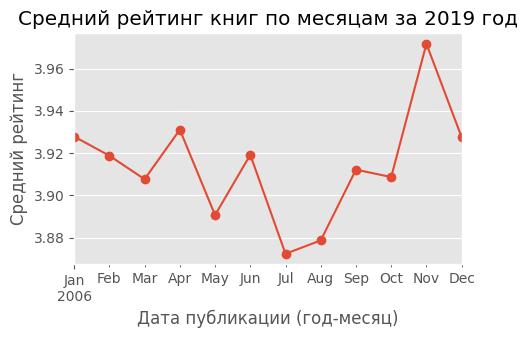

In [120]:
plt.figure(figsize=(5, 3))
average_ratings['2006': '2006-12'].plot(kind='line', marker='o')
plt.title('Средний рейтинг книг по месяцам за 2019 год')
plt.xlabel('Дата публикации (год-месяц)')
plt.ylabel('Средний рейтинг')
plt.grid(True)
plt.show()

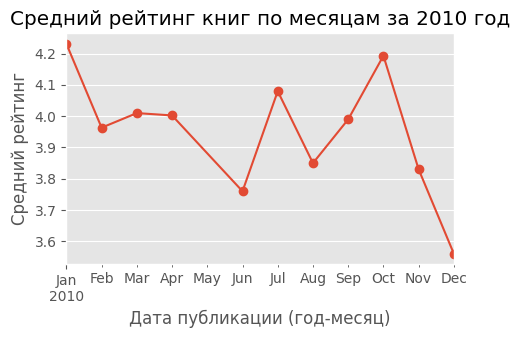

In [121]:
plt.figure(figsize=(5, 3))
average_ratings['2010': '2010-12'].plot(kind='line', marker='o')
plt.title('Средний рейтинг книг по месяцам за 2010 год')
plt.xlabel('Дата публикации (год-месяц)')
plt.ylabel('Средний рейтинг')
plt.grid(True)
plt.show()

На графиках за 2010 и 2019 годы видно, что средний ретинг книг возрастает осенью и убывает зимой и весной

### Визуализация 5:  С помощью box plot сравните распределение рейтинга книг, написанных разными авторами.

In [108]:
print(f"Всего в данных {df.authors.nunique()} уникальных авторов и соавторств")

Всего в данных 6640 уникальных авторов и соавторств


In [109]:
print(f"{sum(df.groupby('authors').size() > 20)} из \
них имеют более 20 изданий книг")

18 из них имеют более 20 изданий книг


In [110]:
author_grouped = df.groupby('authors')['average_rating']\
.apply(list).reset_index()

In [111]:
filtered_authors = author_grouped[author_grouped['average_rating']\
.apply(len) > 20]

In [112]:
exploded_df = filtered_authors.explode('average_rating')

<Figure size 500x300 with 0 Axes>

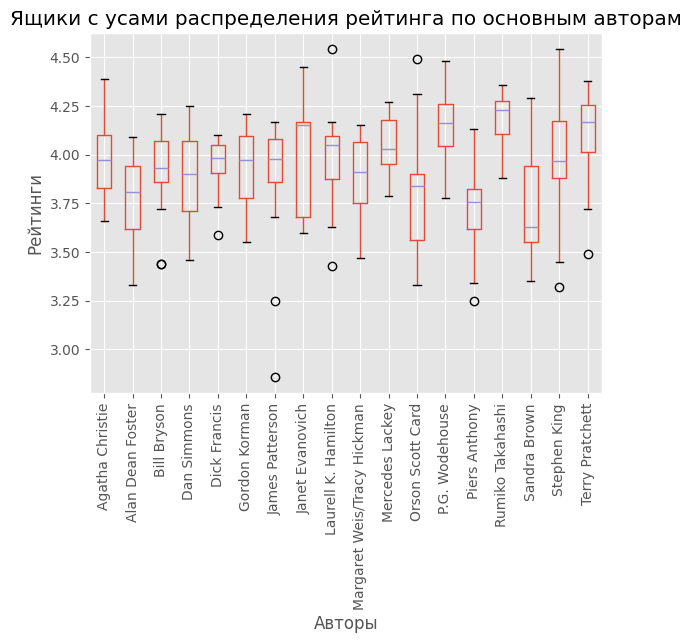

In [113]:
plt.figure(figsize=(5, 3))
exploded_df.boxplot(column='average_rating', by='authors')
plt.title('Ящики с усами распределения рейтинга по основным \
авторам')
plt.suptitle('')  # Suppress the default title to avoid overlap
plt.xlabel('Авторы')
plt.ylabel('Рейтинги')
plt.xticks(rotation=90)
plt.show();

Авторами с наилучшими оценками являются:
1. Rumiko Takahashi
2. P.G. Wodehouse
3. Terry Pratchett
4. Janet Evanovich
5. Agatha Christie

Наибольший размах оценок имеет Стивен кинг, что свидетельствует о разнообразии отношения людей к его творчетву

Количество оценок у авторов разное, но у приведенных авторов они сопоставимы

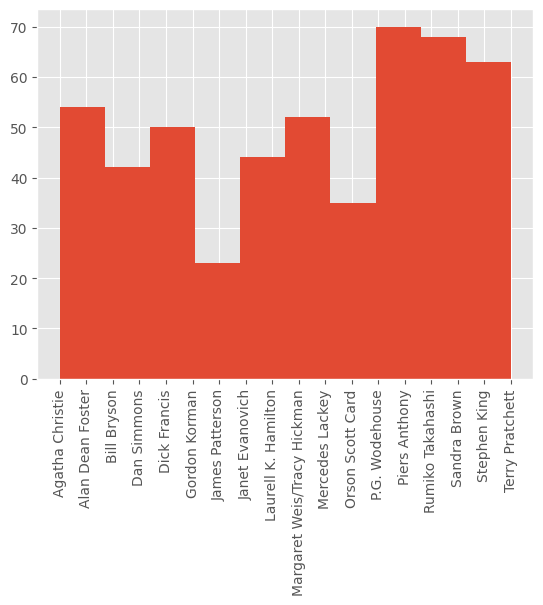

In [119]:
exploded_df.authors.hist()
plt.xticks(rotation=90);

### Визуализация 6: Создайте тепловую карту (heatmap) зависимости рейтинга книги от жанра и количества страниц.

In [68]:
print(f"""В данных содержится  
- Уникальных рейтингов (оценок): {len(df.average_rating.
                                      unique())}
- Уникальных количеств страниц: {len(df.num_pages
                                     .unique())}
- Уникальных категорий: {len(df.category.unique())}
""")

В данных содержится  
- Уникальных рейтингов (оценок): 210
- Уникальных количеств страниц: 998
- Уникальных категорий: 851



Выберем нужные столбцы и очистим данные от пропусков

In [69]:
target_df = df[['average_rating', 'num_pages', \
                'category']].dropna()

Чтобы сжать количество категорий (жанров) и сделать тепловую карту более понятной, с помощью ``ChatGPT`` сгруппируем 851 категорий в 18 жанров и запишем в ``.json`` файл

In [70]:
with open('genre_mapping.json', 'r', encoding='utf-8') as file:
    genre_mapping = json.load(file)

Запишем в строки ``target_df`` соответствующие жанры через обратный мапинг

In [71]:
from collections import defaultdict

inv_map = defaultdict()
for k, vals in genre_mapping.items():
    for v in vals:
        inv_map[v] = k

In [72]:
target_df['Genre'] = target_df['category'].map(inv_map)

Уберем ``category`` из ``target_df``

In [73]:
target_df = target_df[['average_rating', 'num_pages', 'Genre']]

Сгруппируем средние оценки в ``target_df`` по жанру и количеству страниц

In [74]:
grouped_data = target_df.groupby(['Genre', 'num_pages']).agg(
    Avg_Rating=('average_rating', 'mean'),
    Count_Ratings=('average_rating', 'size')
).reset_index()

Для сжатия количества страниц сгруппируем их в диапазоны

In [75]:
# Создание категорий для количества страниц
bins = [0, 100, 200, 300, 400, 500, 600, float('inf')]
labels = ['0-100', '101-200', '201-300', '301-400', \
          '401-500', '501-600', '600+']
grouped_data['Pages_Range'] = pd.\
cut(grouped_data['num_pages'], bins=bins, \
    labels=labels, right=False)

In [76]:
grouped_data

Genre  num_pages  Avg_Rating  Count_Ratings  \
0     Биографии и автобиографии        0.0       4.075              2   
1     Биографии и автобиографии        3.0       3.860              1   
2     Биографии и автобиографии        6.0       3.865              2   
3     Биографии и автобиографии       10.0       4.270              1   
4     Биографии и автобиографии       13.0       3.550              1   
...                         ...        ...         ...            ...   
3218         Юмор и развлечения      384.0       4.125              2   
3219         Юмор и развлечения      400.0       3.970              1   
3220         Юмор и развлечения      416.0       3.780              2   
3221         Юмор и развлечения      448.0       4.220              1   
3222         Юмор и развлечения      640.0       4.020              1   

     Pages_Range  
0          0-100  
1          0-100  
2          0-100  
3          0-100  
4          0-100  
...          ...  
3218     301-400  
3219     401-500  
3220     401-500  
3221     401-500  
3222        600+  

[3223 rows x 5 columns]

Для сжатия количества жанров выявим **11** наиболее популярных

In [77]:
genre_counts = target_df['Genre'].value_counts()

In [78]:
top_genres = list(genre_counts.head(11).index)

Отфильтруем ``grouped_data`` ставим в данных только 11 самых популярных жанров

In [79]:
filtered_data = grouped_data[grouped_data['Genre'].isin(top_genres)]

### **Построим финальную тепловую карту**

In [80]:
pivot_table_2 = filtered_data\
.pivot_table(index='Genre', columns='Pages_Range'\
             , values='Avg_Rating', observed=False)

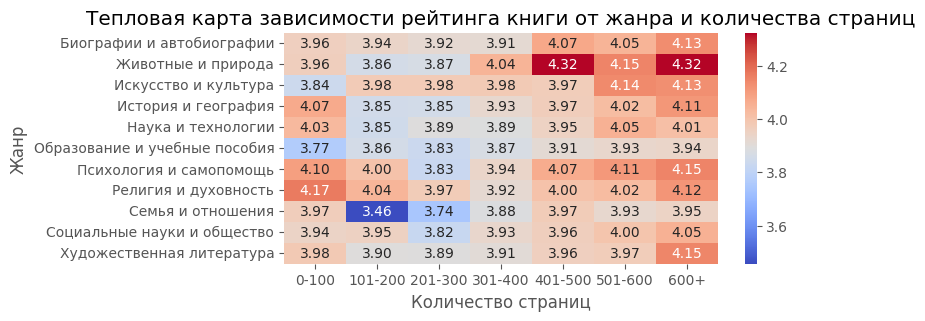

In [81]:
plt.figure(figsize=(7, 3))
heatmap = sns.heatmap(pivot_table_2, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Тепловая карта зависимости рейтинга книги от жанра и количества страниц')
plt.xlabel('Количество страниц')
plt.ylabel('Жанр')
plt.show()

#### **Чтобы убедиться в репрезентативности размеров выборок, построим дополнительную тепловую карту**

Чтобы **лучше видеть маленькие числа**, уберем ``Художественную литературу``

In [82]:
cnt = filtered_data[~filtered_data['Genre'].isin(['Художественная литература'])]

In [83]:
pivot_table_3 = cnt.pivot_table(index='Genre', columns='Pages_Range', values='Count_Ratings', aggfunc='sum', observed=False)

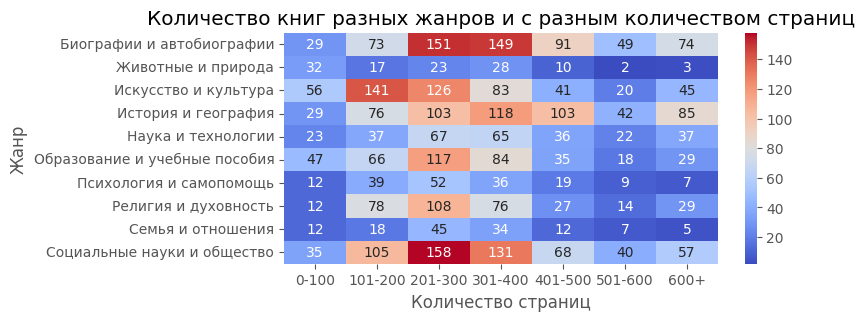

In [84]:
# Визуализация
plt.figure(figsize=(7, 3))
heatmap = sns.heatmap(pivot_table_3, cmap='coolwarm', annot=True, fmt="d")
plt.title('Количество книг разных жанров и с разным количеством страниц')
plt.xlabel('Количество страниц')
plt.ylabel('Жанр')
plt.show()

**Выводы:**  
- С наибольшей достовреностью можно сказать, что короткие книги в категории Семья и отношения имеют низкие оценки
- На малых объемах данных видно, что толстые книги про животных и природу имеют высокие оценки
- По малому объему данных можно предположить, что в среднем наивысшие оценки получают книги с большим количеством страниц
- По малому объему данных можно предположить, что в среднем наименьшие оценки получают книги с количеством страниц 101-400

### Визуализация 7: Постройте bar chart, сравнивающий количество книг, выпущенных в каждом году.

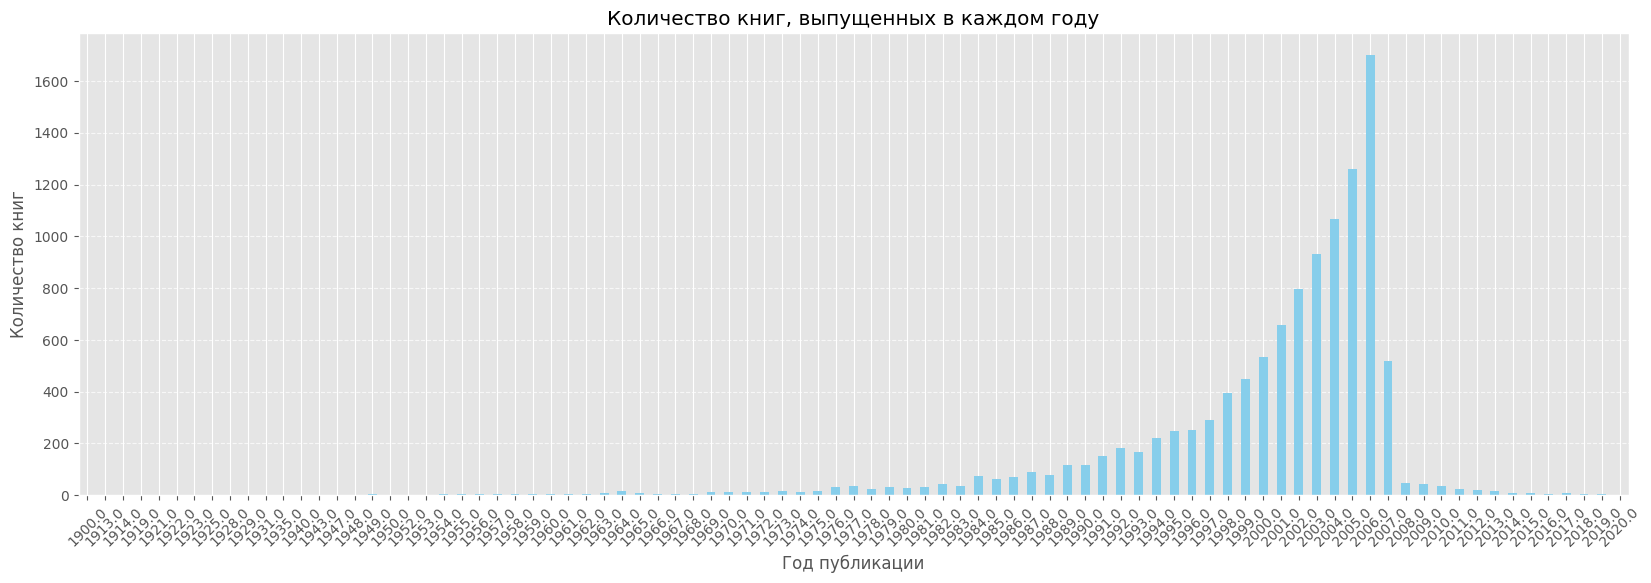

In [85]:
# Преобразуем даты публикации в год
df['publication_year'] = pd.to_datetime(df['publication_date'],\
                                        errors='coerce').dt.year

# Считаем количество книг, выпущенных в каждом году
books_per_year = df['publication_year'].value_counts().sort_index()

# Построение bar chart
plt.figure(figsize=(20, 6))
books_per_year.plot(kind='bar', color='skyblue')
plt.title('Количество книг, выпущенных в каждом году')
plt.xlabel('Год публикации')
plt.ylabel('Количество книг')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

В данных больше всего книг 2005 года издания и большинство книг изданы в период с конца 90-х и до 2007 года

### Визуализация 8: С помощью scatter plot визуализируйте зависимость рейтинга книги от количества страниц.

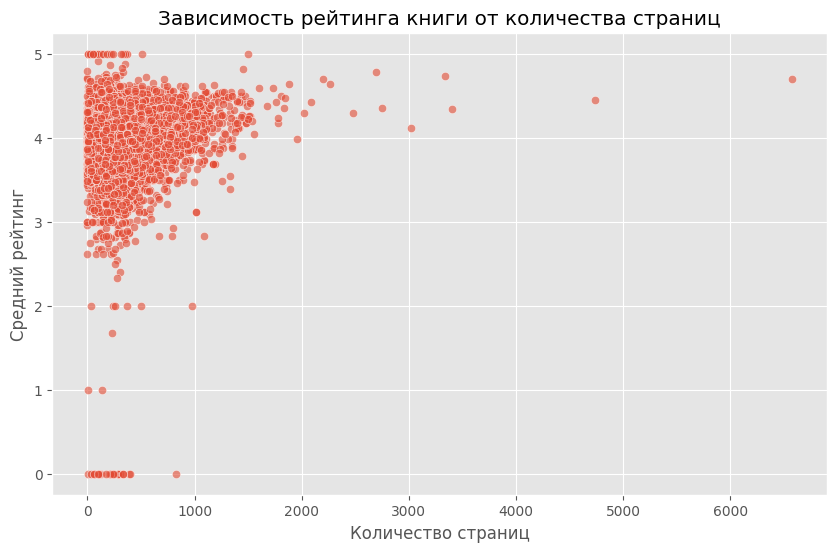

In [86]:
# Извлечение необходимых данных
ratings = df['average_rating']
num_pages = df['num_pages']

# Создание scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(num_pages, ratings, alpha=0.6, edgecolors='w', linewidth=0.5)
plt.title('Зависимость рейтинга книги от количества страниц')
plt.xlabel('Количество страниц')
plt.ylabel('Средний рейтинг')
plt.grid(True)
plt.show()

- Зависимость нелинейная
- Зависимость больше похожа на прямую, чем на обратную

### Визуализация 9: Создайте временную шкалу (timeline), отображающую количество книг, выпущенных в каждом году.

In [87]:
# Преобразуем даты публикации в год
df['publication_year'] = pd.to_datetime(df['publication_date'],\
                                        errors='coerce').dt.year

# Считаем количество книг, выпущенных в каждом году
books_per_year_very_old = df['publication_year']\
.value_counts().sort_index()[:'1948']
books_per_year_old = df['publication_year']\
.value_counts().sort_index()['1947':'1985']
books_per_year_1984 = df['publication_year']\
.value_counts().sort_index()['1983':'2009']
books_per_year_new = df['publication_year'].\
value_counts().sort_index()['2009':]

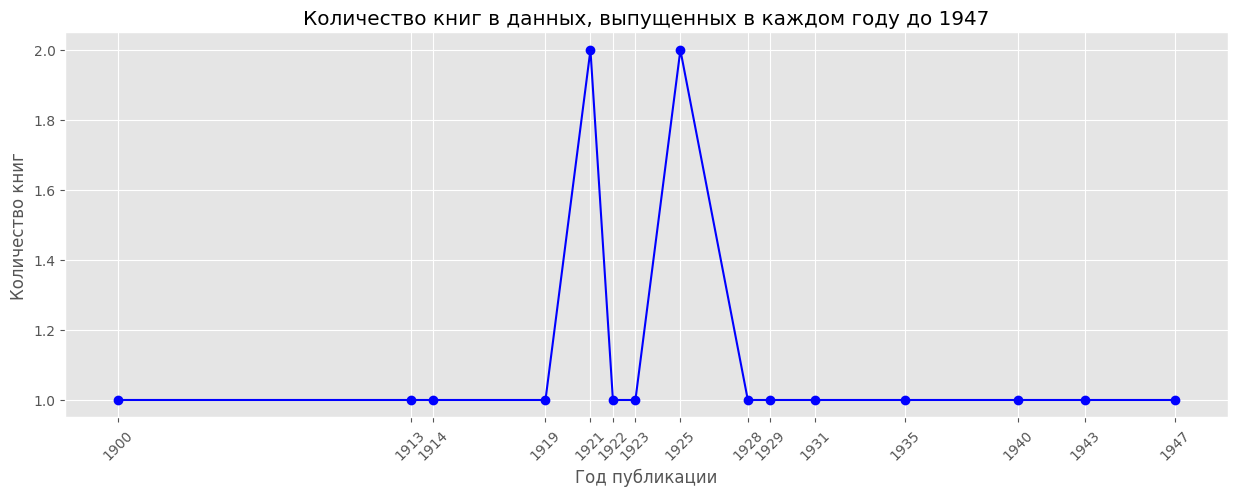

In [88]:
plt.figure(figsize=(15, 5))
plt.plot(books_per_year_very_old.index, books_per_year_very_old.values, marker='o', linestyle='-', color='b')
plt.title('Количество книг в данных, выпущенных в каждом году до 1947')
plt.xlabel('Год публикации')
plt.ylabel('Количество книг')
plt.xticks(books_per_year_very_old.index, rotation=45)
plt.grid(True)
plt.show()

Меньше всего в наборе данных книг иданных в первой половине 20-го века

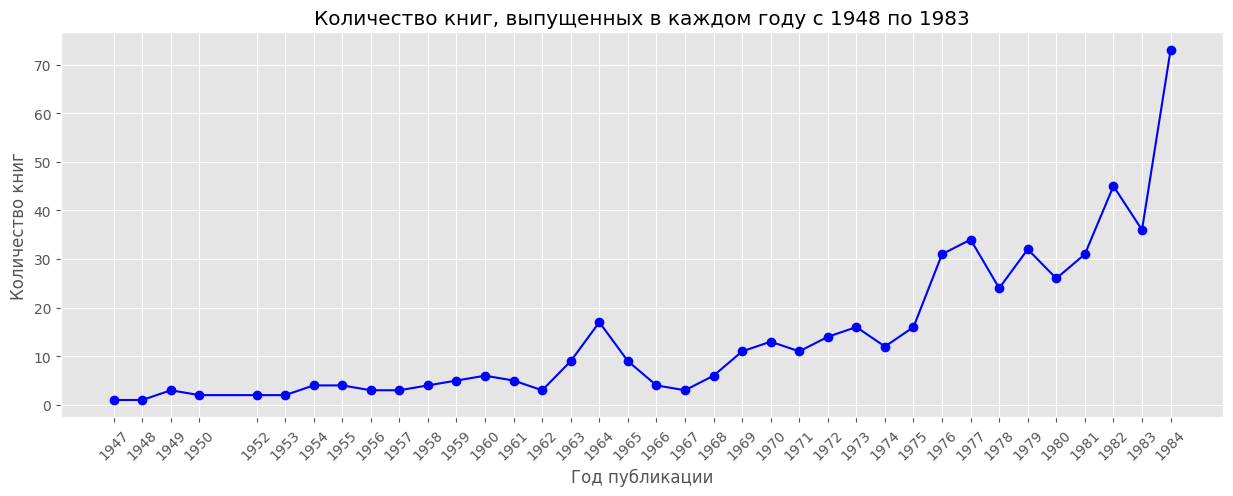

In [89]:
plt.figure(figsize=(15, 5))
plt.plot(books_per_year_old.index, books_per_year_old.values, marker='o', linestyle='-', color='b')
plt.title('Количество книг, выпущенных в каждом году c 1948 по 1983')
plt.xlabel('Год публикации')
plt.ylabel('Количество книг')
plt.xticks(books_per_year_old.index, rotation=45)
plt.grid(True)
plt.show()

В наборе данных во второй половине 20-го века количество изданных книг растет умеренно, экспоненциальный рост начинается примерно в 1984 году

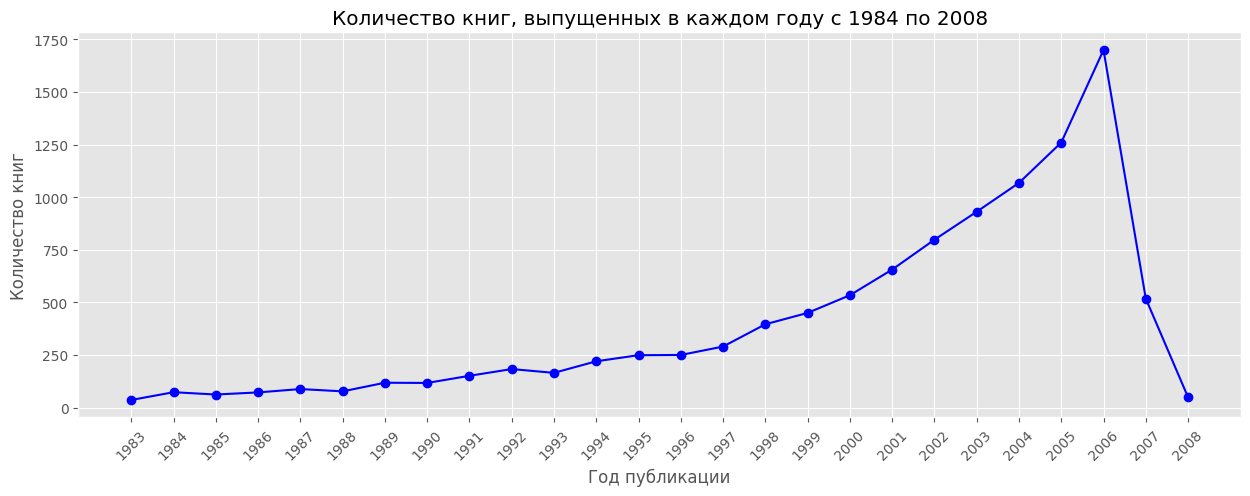

In [90]:
plt.figure(figsize=(15, 5))
plt.plot(books_per_year_1984.index, books_per_year_1984.values, marker='o', linestyle='-', color='b')
plt.title('Количество книг, выпущенных в каждом году c 1984 по 2008')
plt.xlabel('Год публикации')
plt.ylabel('Количество книг')
plt.xticks(books_per_year_1984.index, rotation=45)
plt.grid(True)
plt.show()

С 2006 года по 2008 год в данных произошло резкое падение количество книг

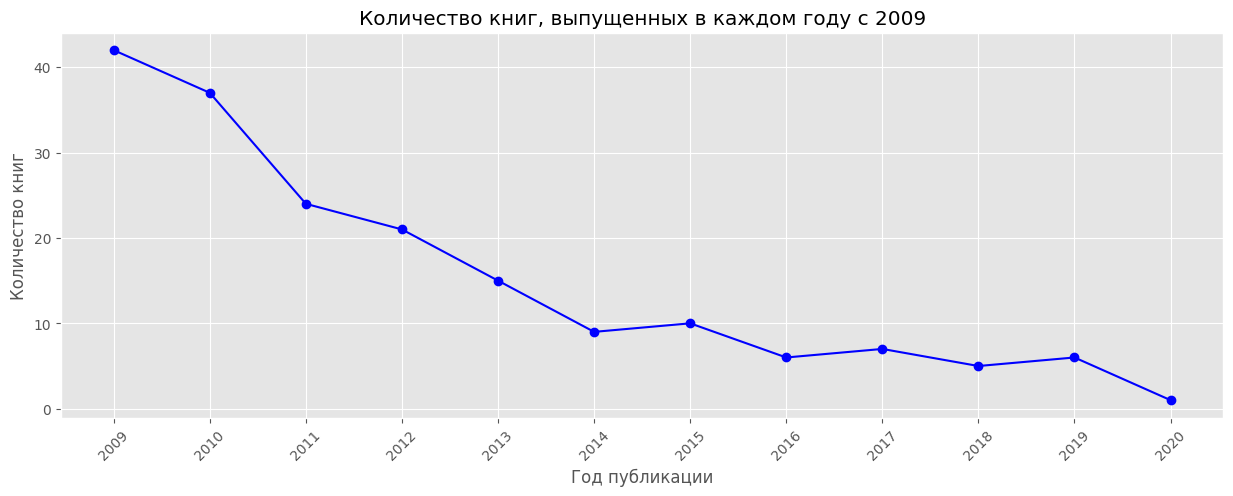

In [91]:
plt.figure(figsize=(15, 5))
plt.plot(books_per_year_new.index, books_per_year_new.values, marker='o', linestyle='-', color='b')
plt.title('Количество книг, выпущенных в каждом году c 2009')
plt.xlabel('Год публикации')
plt.ylabel('Количество книг')
plt.xticks(books_per_year_new.index, rotation=45)
plt.grid(True)
plt.show()

### Визуализация 10: Постройте гистограмму распределения количества страниц в книгах.

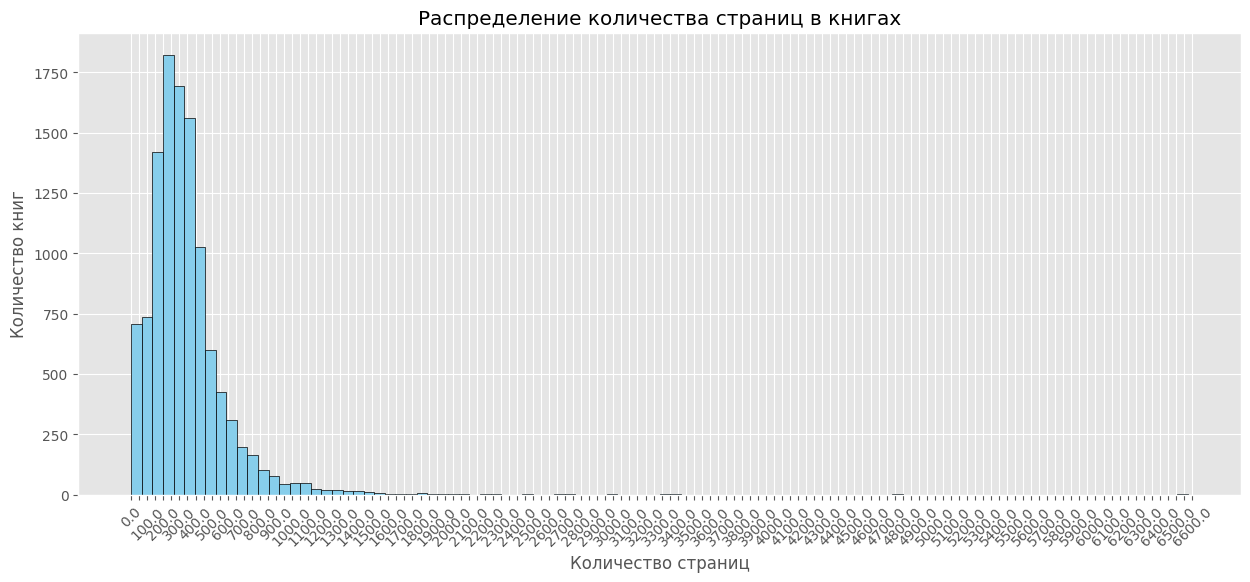

In [92]:
# Извлечение количества страниц
page_counts = df['num_pages']

# Построение гистограммы распределения количества страниц
plt.figure(figsize=(15, 6))
plt.hist(page_counts, bins=100, color='skyblue', edgecolor='black')
plt.title('Распределение количества страниц в книгах')
plt.xlabel('Количество страниц')
plt.ylabel('Количество книг')
tick_labels = np.arange(min(page_counts), max(page_counts) + 50, 50)
tick_labels_str = [str(label) if i % 2 == 0 else '' for i,\
                   label in enumerate(tick_labels)]
plt.xticks(tick_labels, tick_labels_str, rotation=45)
plt.grid(True)
plt.show()

В данных больше всего книг с количеством страниц от 100 до 200. У большинства книг не более 1000 страниц

# Выводы: 
- Был проведен разведочный анализ данных (EDA), их очистка и подготовка к анализу
- В качестве целевых переменных были выбраны:
  - **количество рецензий** (text_reviews_count)
  - **количество оценок** (ratings_count)
- Были написаны SQL-запросы триггеры и хранимые процедуры к БД на основе исходных данных
- Для выявления факторов, влияющих на популярность книг, были построены **визуализации** с использованием библиотек **Pandas, Matplotlib и Seaborn**
- Выявлено, что основная масса книг лежит в диапазоне рейтингов от 3,5 до 4,5
- Были выявлены преобладающие жанры и наиболее высоко оцениваемые и протеворечиые авторы
- Пронализирована сезонность оценок книг
- Была построена тепловая карта для анализа зависимости оценок от жанра и количества страниц (с проверкой сопоставимости размеров выборок)
- Построены распределения количества книг по годам и по количеству страниц
- Тепловая карта не помогла понять, оценки каких жанров растут в зависимости от количества страниц, но в подтвердила общий тренд. Для тепловой карты нужны более равномерно распределенные данные или больше данных

## Дальнейшая работа для увеличения выручки Wildberries от продажи книг:

Из архитектуры похожих рекомендательных систем ([Ozon](https://habr.com/ru/companies/ozontech/articles/750196/)) и [отраслевого отчета Минцифры](https://www.unkniga.ru/media/uploads/otr-doklad-kn-rynok-rossii-2023.pdf) известно, что книги для показа пользователям отбираются из полного католога в 2 этапа:
1. Из 6 млн книг отбираются наиболее популярные 3-5 тыс. книг
2. С помощью ML из 3-5 тыс. книг формируются полки и ранжируются рекомендации

- Наработки из данной работы могут быть использованы для составления соцдем топов и улучшения первого этапа отбора товаров в рекомендательной системе. Ожидается, что это повлияет на Retention по активности и покупкам, а также на LTV и конверсии в продажи. Для проверки гипотез можно проводить A/B-тесты.
- При сопоставимых с конкурентами рекламных бюджетах можно занять большую долю рынка и повысить выручку путем повышения конверсий в продажи, Retention по активности и повторным покупкам и LTV текущих и привлекаемых пользователей.

## Возможности для роста
- Российский книжный рынок демонстрирует устойчивый рост, достигнув в 2023 году объема в 108,2 млрд рублей (с учтеном печатных и цифровый изданий).
- Продажи печатных книг составили 94 млрд рублей, увеличившись на 9% по сравнению с предыдущим годом.
- Интернет-каналы впервые заняли более 50% рынка печатных книг и стали ключевым драйвером роста отрасли.
- В 2023 году оборот интернет-канала достиг 45,72 млрд рублей, что на 25,3% больше, чем в предыдущем году.
- Рынок цифровых книг достиг 14,2 млрд рублей, показав рост на 19%.
> **Источник:** Книжный рынок России. Состояние, тенденции и перспективы развития. Год 2023: Отраслевой доклад. Выпуск XVI / Под общ. ред. В.В.Григорьева. – М.: Министерство цифрового развития, связи и массовых коммуникаций Российской Федерации, 2024.  
**[Читать доклад](https://www.unkniga.ru/media/uploads/otr-doklad-kn-rynok-rossii-2023.pdf)**
- **Растущие рынки предоставляют компаниям возможности для роста.**

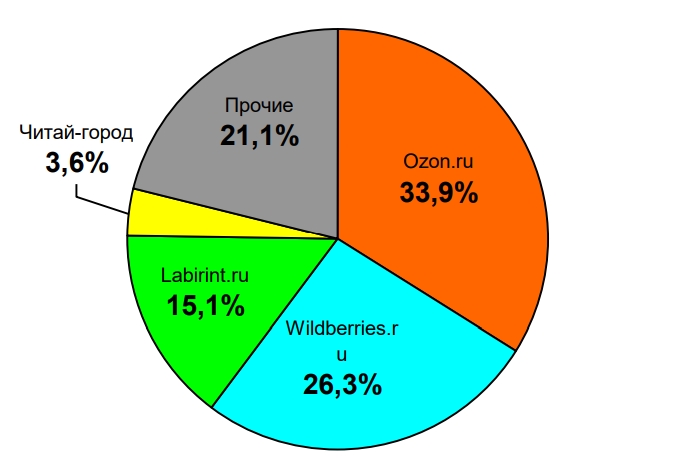

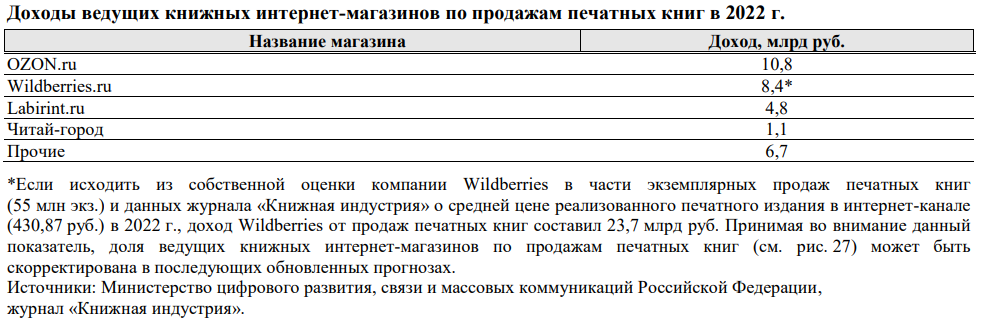